In [1]:
from pathlib import Path
from functools import partial

import numpy as onp

import matplotlib.pyplot as plt

import optax

import haiku as hk

from jax import numpy as jnp, random

from jax_md import space, energy, partition, simulate

In [2]:
from chemtrain.jax_md_mod import io, custom_space, custom_energy
from chemtrain import trainers, trajectory, util, quantity
from chemtrain.potential import neural_networks, layers

In [3]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# DiffTRe: CG Water on Structural Data

This example, based on the paper [Learning neural network potentials from experimental data via Differentiable Trajectory Reweighting](https://www.nature.com/articles/s41467-021-27241-4),
employs DiffTRe with an adaptive scaling of the learning rate to learn a
structurally accurate coarse-grained model for water.

## Introduction

Classical approaches to Top-Down learning of potential models, e.g., Iterative Boltzmann Inversion [^Reith2003] or Inverse Monte Carlo [^Lyubartsev1995], only learn pair-wise dependencies between particles.
However, to correctly predict the anomalous properties of water, it is necessary that the water model correctly represents triplet interactions [^Dhabal2014].

Therefore, the DiffTRe algorithm [^Thaler2021] leverages umbrella sampling [^Torrie1977] to flexibly train arbitrary potential models on experimental reference data.

We present the details of the approach in the toy example [Differentiable Trajectory Reweighting (DiffTRe)](/algorithms/difftre).

## Setup Training

First, we need to create a reference system, in which we can predict macroscopic measurements.
Therefore, we load a box of 901 water particles and construct a periodic space.
Additionally, we initialize a neighbor list, which enables accelerating the simulation and the extraction of a neighborlist graph for the Graph Neural Network (GNN) model.

### System

In [4]:
system: quantity.util.InitArguments = {}

file = 'water/data/confs/Water_experimental_3nm.gro'

box, r_init, _, _ = io.load_box(file)  # initial configuration
mass = 18.0154

box_tensor, scale_fn = custom_space.init_fractional_coordinates(box)
displacement_fn, shift_fn = space.periodic_general(
    box_tensor, fractional_coordinates=True, wrapped=True)
r_init = scale_fn(r_init)

neighbor_fn = partition.neighbor_list(
    displacement_fn, box, r_cutoff=0.5, dr_threshold=0.0,
    disable_cell_list=True, fractional_coordinates=True
)
nbrs_init = neighbor_fn.allocate(r_init, capacity_multiplier=1.5, extra_capacity=0)

system.update({
    "displacement_fn": displacement_fn,
    "reference_box": box_tensor,
    "nbrs_init": nbrs_init,
    "r_init": r_init
})

### Model

Next, we construct a potential model for the reference system.
We use the expressive DimeNet architecture [^DimeNet] and employ a $\Delta$-learning approach based on a prior.
The prior stabilizes the simulation in the first epochs and additionally should enforce physical constraints.
Like the paper, we choose a simple repulsive prior based on the repulsive term of the Lennard Jones potential.
Consequently, the system directly respects the Pauli exclusion principle.

In [5]:
mlp_init = {
    'b_init': hk.initializers.Constant(0.),
    'w_init': layers.OrthogonalVarianceScalingInit(scale=1.)
    }

model_init, model_apply = neural_networks.dimenetpp_neighborlist(
    displacement_fn, 0.5, 1, r_init, nbrs_init,
    embed_size=32, init_kwargs=mlp_init,
)

prior_energy_apply = custom_energy.generic_repulsion_neighborlist(
    displacement_fn, box, sigma=0.3165, epsilon=1.0, exp=12.0,
    r_onset=0.45, r_cutoff=0.5, initialize_neighbor_list=False)

def energy_fn_template(energy_params):
    def energy_fn(pos, neighbor, **dyn_kwargs):
        gnn_energy = model_apply(energy_params, pos, neighbor, **dyn_kwargs)

        prior_energy = prior_energy_apply(pos, neighbor, **dyn_kwargs)

        return prior_energy + gnn_energy

    return energy_fn

init_model_params = model_init(random.PRNGKey(11), r_init, nbrs_init)

Capping edges and triplets. Beware of overflow, which is currently not being detected.


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:212: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


### Simulator

As outlined in the [Differentiable Trajectory Reweighting (DiffTRe)](/algorithms/difftre) example, a molecular dynamics simulation is an efficient method to sample particle position from the equilibrium distribution.
Hence, we set up a simulation routine based on a Nosé-Hoover integrator for a total time of $70\ \text{ps}$.
Since the samples should be uncorrelated, we subsample the trajectory every $0.1\ \text{ps}$ and additionally substract the first $10\ \text{ps}$ to account for the changing potential model.

In [6]:
system_temperature = 296.15  # Kelvin
boltzmann_constant = 0.0083145107  # in kJ / mol K
kbt = system_temperature * boltzmann_constant

time_step = 0.01
total_time = 70.
t_equilib = 20.
print_every = 0.1

timings = trajectory.traj_util.process_printouts(
    time_step, total_time, t_equilib, print_every
)

In [7]:
# The simulator template enables to initialize a 
# new simulation routine whenever the potential model
# changes.
simulator_template = partial(
    simulate.nvt_nose_hoover, shift_fn=shift_fn,
    dt=time_step, kT=kbt, tau=50. * time_step, chain_length=3, chain_steps=1
)

# We need an initial state of the simulator, where
# we can start the simulations from.
simulator_init, _ = simulator_template(
    energy_fn_template(init_model_params)
)

init_simulator_state = simulator_init(
    random.PRNGKey(11), r_init, neighbor=nbrs_init, mass=mass
)
reference_simulation_state = trajectory.traj_util.SimulatorState(
    sim_state=init_simulator_state, nbrs=nbrs_init
)

### Targets

Next, we can set up the macroscopic properties we want to match.
We use the experimentally determined RDF and ADF at $296.15\ \text{K}$ [^Soper2008] and additionally the pressure target of $1\ \text{bar}$.

In [8]:
reference_rdf = onp.loadtxt("water/data/experimental/O_O_RDF.csv")
reference_adf = onp.loadtxt("water/data/experimental/O_O_O_ADF.csv")
pressure_target = 1. / 16.6054   # 1 bar in kJ / mol nm^3

In [9]:
target_builder = quantity.TargetBuilder(system, strict=True)

target_builder["rdf"] = quantity.structure.init_radial_distribution_target(
    reference_rdf, nbins=300, rdf_cut=1.0, gamma=1.0
)
target_builder["adf"] = quantity.structure.init_angular_distribution_target(
    reference_adf, nbins=150, r_outer=0.318, gamma=1.0
)
target_builder["pressure"] = quantity.thermodynamics.init_pressure_target(
    energy_fn_template, include_kinetic=False, gamma=1.0e-7, target=pressure_target
)

targets, compute_fns = target_builder.build()

[ADF] Estimates 498644 max. triplets in neighbor list and 23308 max. triplets in cutoff-shell.


### Trainer

Finally, we can use the potential model, simulation routines, and targets to initialize the DiffTRe algorithm.
Therefore, we use the high-level interface, called trainer.
It is possible to add multiple statepoints to the trainer, e.g., to train different systems at different thermodynamic state points.
However, here we only set up a single state points.
We set the reweighting ratio to 0.9, such that the computed trajectories might be re-used if the updated potential and the reference potential are sufficiently close.

In [10]:
check_freq = None
num_updates = 300

initial_lr = 0.003

lr_schedule = optax.exponential_decay(initial_lr, num_updates, 0.01)
optimizer = optax.chain(
    optax.scale_by_adam(0.1, 0.4),
    optax.scale_by_schedule(lr_schedule),
    optax.scale_by_learning_rate(1.0, flip_sign=True)
)

trainer = trainers.Difftre(init_model_params,
                           optimizer,
                           energy_fn_template=energy_fn_template)

In [11]:
trainer.add_statepoint(energy_fn_template, simulator_template,
                       neighbor_fn, timings, {'kT': kbt}, compute_fns,
                       reference_simulation_state, targets)

/home/paul/chemtrain/chemtrain/trajectory/reweighting.py:790: UserWarning: Propagation function is not safe by default. Do not forget to use the wrapper around the compute function to ensure that the neighborlist does not overflow.
  warnings.warn(


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:148: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


/home/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:212: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


Time for trajectory initialization 0: 0.8261173685391744 mins


In [12]:
trainer.init_step_size_adaption(0.10)

[Step size] Use 5 iterations for 10 interior points.


## Train

In [13]:
trainer.train(num_updates, checkpoint_freq=None)
trainer.save_trainer("water/output/cg_water_example.pkl", ".pkl")

[Step Size] Found optimal step size 0.11646263301372528 with residual 0.00012969970703125



[DiffTRe] Epoch 0
	Epoch loss = 0.19103
	Gradient norm: 0.1356312483549118
	Elapsed time = 2.920 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 7.942501724755857e-06
	Predicted free_energy: 8.923435962060466e-05
	Predicted pressure: 667.1107788085938


[Step Size] Found optimal step size 0.09630772471427917 with residual 0.0002570152282714844



[DiffTRe] Epoch 1
	Epoch loss = 0.17203
	Gradient norm: 0.12802192568778992
	Elapsed time = 2.689 min
[Statepoint 0]
	kT = 2.450 ref_kT = 2.462
	Predicted entropy: 0.579969048500061
	Predicted free_energy: -169.37730407714844
	Predicted pressure: 636.3814086914062


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.06174349784851074



[DiffTRe] Epoch 2
	Epoch loss = 0.15626
	Gradient norm: 0.17260897159576416
	Elapsed time = 2.702 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: 1.004400372505188
	Predicted free_energy: -315.7657775878906
	Predicted pressure: 605.7669067382812


[Step Size] Found optimal step size 0.08190250396728516 with residual 0.009772539138793945



[DiffTRe] Epoch 3
	Epoch loss = 0.14267
	Gradient norm: 0.16704203188419342
	Elapsed time = 2.703 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: 1.4072855710983276
	Predicted free_energy: -452.358642578125
	Predicted pressure: 578.72900390625


[Step Size] Found optimal step size 0.06880739331245422 with residual 0.00011348724365234375



[DiffTRe] Epoch 4
	Epoch loss = 0.12912
	Gradient norm: 0.23225824534893036
	Elapsed time = 2.709 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 1.8181695938110352
	Predicted free_energy: -597.4717407226562
	Predicted pressure: 556.10107421875


[Step Size] Found optimal step size 0.06744759529829025 with residual 7.033348083496094e-05



[DiffTRe] Epoch 5
	Epoch loss = 0.11782
	Gradient norm: 0.19114157557487488
	Elapsed time = 2.708 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 2.127558708190918
	Predicted free_energy: -758.139404296875
	Predicted pressure: 527.9712524414062


[Step Size] Found optimal step size 0.056283533573150635 with residual 0.0012888908386230469



[DiffTRe] Epoch 6
	Epoch loss = 0.10730
	Gradient norm: 0.20673471689224243
	Elapsed time = 2.696 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: 2.3672566413879395
	Predicted free_energy: -942.9878540039062
	Predicted pressure: 502.20086669921875


[Step Size] Found optimal step size 0.06161719560623169 with residual 0.001413583755493164



[DiffTRe] Epoch 7
	Epoch loss = 0.09825
	Gradient norm: 0.15900519490242004
	Elapsed time = 2.700 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: 2.5686984062194824
	Predicted free_energy: -1116.3572998046875
	Predicted pressure: 478.932373046875


[Step Size] Found optimal step size 0.05355771631002426 with residual 0.0014007091522216797



[DiffTRe] Epoch 8
	Epoch loss = 0.08924
	Gradient norm: 0.2412528246641159
	Elapsed time = 2.697 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 2.76936674118042
	Predicted free_energy: -1271.210205078125
	Predicted pressure: 455.0650329589844


[Step Size] Found optimal step size 0.046181246638298035 with residual 0.0003399848937988281



[DiffTRe] Epoch 9
	Epoch loss = 0.08127
	Gradient norm: 0.18372927606105804
	Elapsed time = 2.698 min
[Statepoint 0]
	kT = 2.468 ref_kT = 2.462
	Predicted entropy: 2.9228973388671875
	Predicted free_energy: -1449.210693359375
	Predicted pressure: 430.7251892089844


[Step Size] Found optimal step size 0.05553843453526497 with residual 0.002583026885986328



[DiffTRe] Epoch 10
	Epoch loss = 0.07596
	Gradient norm: 0.1570090502500534
	Elapsed time = 2.701 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: 3.0435216426849365
	Predicted free_energy: -1578.072021484375
	Predicted pressure: 416.3880310058594


[Step Size] Found optimal step size 0.0560724250972271 with residual 0.0015625953674316406



[DiffTRe] Epoch 11
	Epoch loss = 0.06971
	Gradient norm: 0.1119617372751236
	Elapsed time = 2.703 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 3.1312859058380127
	Predicted free_energy: -1754.8358154296875
	Predicted pressure: 395.5330810546875


[Step Size] Found optimal step size 0.0535639263689518 with residual 0.0011000633239746094



[DiffTRe] Epoch 12
	Epoch loss = 0.06400
	Gradient norm: 0.13304631412029266
	Elapsed time = 2.700 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: 3.2113561630249023
	Predicted free_energy: -1858.22607421875
	Predicted pressure: 377.4339904785156


[Step Size] Found optimal step size 0.07493582367897034 with residual 0.0007491111755371094



[DiffTRe] Epoch 13
	Epoch loss = 0.05935
	Gradient norm: 0.07252632081508636
	Elapsed time = 2.701 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 3.30344295501709
	Predicted free_energy: -1964.234619140625
	Predicted pressure: 364.0181884765625


[Step Size] Found optimal step size 0.05227863788604736 with residual 0.0001392364501953125



[DiffTRe] Epoch 14
	Epoch loss = 0.05420
	Gradient norm: 0.06779029220342636
	Elapsed time = 2.704 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: 3.4637222290039062
	Predicted free_energy: -1984.869384765625
	Predicted pressure: 363.1494445800781


[Step Size] Found optimal step size 0.07281851023435593 with residual 0.002334117889404297



[DiffTRe] Epoch 15
	Epoch loss = 0.05072
	Gradient norm: 0.041721243411302567
	Elapsed time = 2.702 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 3.527883291244507
	Predicted free_energy: -2146.51025390625
	Predicted pressure: 345.3955078125


[Step Size] Found optimal step size 0.046994648873806 with residual 0.0008411407470703125



[DiffTRe] Epoch 16
	Epoch loss = 0.04714
	Gradient norm: 0.06377094984054565
	Elapsed time = 2.707 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: 3.661432981491089
	Predicted free_energy: -2093.930908203125
	Predicted pressure: 344.1494445800781


[Step Size] Found optimal step size 0.09729498624801636 with residual 2.956390380859375e-05



[DiffTRe] Epoch 17
	Epoch loss = 0.04551
	Gradient norm: 0.023103982210159302
	Elapsed time = 2.704 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 3.6687514781951904
	Predicted free_energy: -2273.284423828125
	Predicted pressure: 330.5783996582031


[Step Size] Found optimal step size 0.08108288794755936 with residual 0.0009706020355224609



[DiffTRe] Epoch 18
	Epoch loss = 0.04236
	Gradient norm: 0.018263863399624825
	Elapsed time = 2.707 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: 3.9044411182403564
	Predicted free_energy: -2157.87646484375
	Predicted pressure: 340.6921081542969


[Step Size] Found optimal step size 0.05130379647016525 with residual 8.416175842285156e-05



[DiffTRe] Epoch 19
	Epoch loss = 0.04096
	Gradient norm: 0.026316501200199127
	Elapsed time = 2.708 min
[Statepoint 0]
	kT = 2.471 ref_kT = 2.462
	Predicted entropy: 3.9732825756073
	Predicted free_energy: -2275.769287109375
	Predicted pressure: 341.1780090332031


[Step Size] Found optimal step size 0.05819595232605934 with residual 0.0016453266143798828



[DiffTRe] Epoch 20
	Epoch loss = 0.04009
	Gradient norm: 0.02832428365945816
	Elapsed time = 2.712 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 4.111354827880859
	Predicted free_energy: -2070.59814453125
	Predicted pressure: 358.2225036621094


[Step Size] Found optimal step size 0.19500839710235596 with residual 0.0004658699035644531



[DiffTRe] Epoch 21
	Epoch loss = 0.03871
	Gradient norm: 0.005490739364176989
	Elapsed time = 2.714 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 4.0304083824157715
	Predicted free_energy: -2495.965576171875
	Predicted pressure: 320.12115478515625


[Step Size] Found optimal step size 0.13276785612106323 with residual 0.00022077560424804688



[DiffTRe] Epoch 22
	Epoch loss = 0.03704
	Gradient norm: 0.0039050783962011337
	Elapsed time = 2.715 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 4.2354536056518555
	Predicted free_energy: -2853.604248046875
	Predicted pressure: 301.82452392578125


[Step Size] Found optimal step size 0.10298876464366913 with residual 0.0011284351348876953



[DiffTRe] Epoch 23
	Epoch loss = 0.03555
	Gradient norm: 0.006110412068665028
	Elapsed time = 2.713 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: 4.282986164093018
	Predicted free_energy: -3268.4375
	Predicted pressure: 285.7274169921875


[Step Size] Found optimal step size 0.04381556436419487 with residual 0.00014472007751464844



[DiffTRe] Epoch 24
	Epoch loss = 0.03472
	Gradient norm: 0.010918434709310532
	Elapsed time = 2.718 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: 4.349307060241699
	Predicted free_energy: -3425.649658203125
	Predicted pressure: 279.2060852050781


[Step Size] Found optimal step size 0.07977276295423508 with residual 0.0005316734313964844



[DiffTRe] Epoch 25
	Epoch loss = 0.03414
	Gradient norm: 0.0058218021877110004
	Elapsed time = 2.717 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 4.3840413093566895
	Predicted free_energy: -3408.73291015625
	Predicted pressure: 286.93536376953125


[Step Size] Found optimal step size 0.05888517200946808 with residual 0.000579833984375



[DiffTRe] Epoch 26
	Epoch loss = 0.03431
	Gradient norm: 0.03151208907365799
	Elapsed time = 2.722 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: 4.482857704162598
	Predicted free_energy: -3299.0
	Predicted pressure: 301.80291748046875


[Step Size] Found optimal step size 0.21066787838935852 with residual 0.002720355987548828



[DiffTRe] Epoch 27
	Epoch loss = 0.03306
	Gradient norm: 0.0021364272106438875
	Elapsed time = 2.719 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 4.331233501434326
	Predicted free_energy: -3857.7158203125
	Predicted pressure: 258.2695007324219


[Step Size] Found optimal step size 0.0653737336397171 with residual 0.021349430084228516



[DiffTRe] Epoch 28
	Epoch loss = 0.03147
	Gradient norm: 0.008684496395289898
	Elapsed time = 2.737 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: 4.2325358390808105
	Predicted free_energy: -4744.640625
	Predicted pressure: 213.1644744873047


[Step Size] Found optimal step size 0.2644701600074768 with residual 0.02908778190612793



[DiffTRe] Epoch 29
	Epoch loss = 0.03155
	Gradient norm: 0.002668860135599971
	Elapsed time = 2.704 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 4.262420654296875
	Predicted free_energy: -4548.39697265625
	Predicted pressure: 228.2977752685547


[Step Size] Found optimal step size 0.06465347111225128 with residual 0.0003020763397216797



[DiffTRe] Epoch 30
	Epoch loss = 0.02958
	Gradient norm: 0.007060658652335405
	Elapsed time = 2.722 min
[Statepoint 0]
	kT = 2.454 ref_kT = 2.462
	Predicted entropy: 4.1731157302856445
	Predicted free_energy: -5498.09814453125
	Predicted pressure: 191.00245666503906


[Step Size] Found optimal step size 0.048844970762729645 with residual 0.027605533599853516



[DiffTRe] Epoch 31
	Epoch loss = 0.02867
	Gradient norm: 0.009643757715821266
	Elapsed time = 2.711 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: 4.239561080932617
	Predicted free_energy: -5662.7626953125
	Predicted pressure: 182.14842224121094


[Step Size] Found optimal step size 0.054942354559898376 with residual 0.0012650489807128906



[DiffTRe] Epoch 32
	Epoch loss = 0.02863
	Gradient norm: 0.011492052115499973
	Elapsed time = 2.716 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 4.244324207305908
	Predicted free_energy: -5370.89453125
	Predicted pressure: 204.86724853515625


[Step Size] Found optimal step size 0.09341426193714142 with residual 0.00032901763916015625



[DiffTRe] Epoch 33
	Epoch loss = 0.02784
	Gradient norm: 0.006838821806013584
	Elapsed time = 2.717 min
[Statepoint 0]
	kT = 2.471 ref_kT = 2.462
	Predicted entropy: 4.245877742767334
	Predicted free_energy: -5723.00439453125
	Predicted pressure: 181.06761169433594


[Step Size] Found optimal step size 0.06648516654968262 with residual 0.004840850830078125



[DiffTRe] Epoch 34
	Epoch loss = 0.02808
	Gradient norm: 0.005736091639846563
	Elapsed time = 2.721 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 4.182639122009277
	Predicted free_energy: -5609.95703125
	Predicted pressure: 191.7781982421875


[Step Size] Found optimal step size 0.10758353769779205 with residual 0.00012254714965820312



[DiffTRe] Epoch 35
	Epoch loss = 0.02800
	Gradient norm: 0.004680092446506023
	Elapsed time = 2.717 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 4.107640266418457
	Predicted free_energy: -6116.2998046875
	Predicted pressure: 170.89772033691406


[Step Size] Found optimal step size 0.12452211230993271 with residual 0.0010972023010253906



[DiffTRe] Epoch 36
	Epoch loss = 0.02672
	Gradient norm: 0.0018761394312605262
	Elapsed time = 2.722 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: 4.1471662521362305
	Predicted free_energy: -5956.83154296875
	Predicted pressure: 182.12289428710938


[Step Size] Found optimal step size 0.08265381306409836 with residual 0.3399691581726074



[DiffTRe] Epoch 37
	Epoch loss = 0.02623
	Gradient norm: 0.0026447551790624857
	Elapsed time = 2.720 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 4.027464866638184
	Predicted free_energy: -6650.47265625
	Predicted pressure: 152.50778198242188


[Step Size] Found optimal step size 0.11782864481210709 with residual 0.0037064552307128906



[DiffTRe] Epoch 38
	Epoch loss = 0.02557
	Gradient norm: 0.0031116625759750605
	Elapsed time = 2.714 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 4.0158796310424805
	Predicted free_energy: -6337.89404296875
	Predicted pressure: 173.7356414794922


[Step Size] Found optimal step size 0.04058059677481651 with residual 0.01288461685180664



[DiffTRe] Epoch 39
	Epoch loss = 0.02516
	Gradient norm: 0.008814167231321335
	Elapsed time = 2.713 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 3.821241855621338
	Predicted free_energy: -6700.66650390625
	Predicted pressure: 160.57704162597656


[Step Size] Found optimal step size 0.06773321330547333 with residual 0.0009520053863525391



[DiffTRe] Epoch 40
	Epoch loss = 0.02474
	Gradient norm: 0.003472318407148123
	Elapsed time = 2.707 min
[Statepoint 0]
	kT = 2.471 ref_kT = 2.462
	Predicted entropy: 3.8839566707611084
	Predicted free_energy: -6487.48486328125
	Predicted pressure: 170.49232482910156


[Step Size] Found optimal step size 0.060729287564754486 with residual 0.007171154022216797



[DiffTRe] Epoch 41
	Epoch loss = 0.02440
	Gradient norm: 0.009781386703252792
	Elapsed time = 2.713 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: 3.819136381149292
	Predicted free_energy: -6607.2939453125
	Predicted pressure: 162.90585327148438


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.2635622024536133



[DiffTRe] Epoch 42
	Epoch loss = 0.02469
	Gradient norm: 0.0028380730655044317
	Elapsed time = 2.714 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: 3.7133824825286865
	Predicted free_energy: -7068.71826171875
	Predicted pressure: 142.43836975097656


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.23050832748413086



[DiffTRe] Epoch 43
	Epoch loss = 0.02381
	Gradient norm: 0.0023482595570385456
	Elapsed time = 2.714 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: 3.7937467098236084
	Predicted free_energy: -6960.90380859375
	Predicted pressure: 152.22604370117188


[Step Size] Found optimal step size 0.08265381306409836 with residual 0.2437882423400879



[DiffTRe] Epoch 44
	Epoch loss = 0.02370
	Gradient norm: 0.004011994227766991
	Elapsed time = 2.717 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: 3.742128610610962
	Predicted free_energy: -6942.98583984375
	Predicted pressure: 159.97909545898438


[Step Size] Found optimal step size 0.07322831451892853 with residual 0.0025243759155273438



[DiffTRe] Epoch 45
	Epoch loss = 0.02291
	Gradient norm: 0.010999626480042934
	Elapsed time = 2.721 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 3.720419406890869
	Predicted free_energy: -7226.04833984375
	Predicted pressure: 138.60194396972656


[Step Size] Found optimal step size 0.07233420014381409 with residual 0.0016870498657226562



[DiffTRe] Epoch 46
	Epoch loss = 0.02291
	Gradient norm: 0.0036964500322937965
	Elapsed time = 2.722 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: 3.847076416015625
	Predicted free_energy: -6832.8623046875
	Predicted pressure: 167.6994171142578


[Step Size] Found optimal step size 0.19534990191459656 with residual 0.0007557868957519531



[DiffTRe] Epoch 47
	Epoch loss = 0.02256
	Gradient norm: 0.0023708725348114967
	Elapsed time = 2.726 min
[Statepoint 0]
	kT = 2.470 ref_kT = 2.462
	Predicted entropy: 3.8505172729492188
	Predicted free_energy: -6708.583984375
	Predicted pressure: 177.50634765625


[Step Size] Found optimal step size 0.044181905686855316 with residual 0.00142669677734375



[DiffTRe] Epoch 48
	Epoch loss = 0.02133
	Gradient norm: 0.013841172680258751
	Elapsed time = 2.726 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 3.6754961013793945
	Predicted free_energy: -7534.4345703125
	Predicted pressure: 139.1604766845703


[Step Size] Found optimal step size 0.1540963053703308 with residual 0.0002231597900390625



[DiffTRe] Epoch 49
	Epoch loss = 0.02139
	Gradient norm: 0.003109158016741276
	Elapsed time = 2.727 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: 3.695502281188965
	Predicted free_energy: -7275.4677734375
	Predicted pressure: 156.9134979248047


[Step Size] Found optimal step size 0.168358713388443 with residual 0.00029659271240234375



[DiffTRe] Epoch 50
	Epoch loss = 0.02068
	Gradient norm: 0.0014812848530709743
	Elapsed time = 2.729 min
[Statepoint 0]
	kT = 2.453 ref_kT = 2.462
	Predicted entropy: 3.5273680686950684
	Predicted free_energy: -7829.5302734375
	Predicted pressure: 133.35244750976562


[Step Size] Found optimal step size 0.06406360864639282 with residual 0.0011510848999023438



[DiffTRe] Epoch 51
	Epoch loss = 0.02054
	Gradient norm: 0.01121461484581232
	Elapsed time = 2.757 min
[Statepoint 0]
	kT = 2.470 ref_kT = 2.462
	Predicted entropy: 3.629861831665039
	Predicted free_energy: -7867.443359375
	Predicted pressure: 139.90408325195312


[Step Size] Found optimal step size 0.050937455147504807 with residual 0.0002503395080566406



[DiffTRe] Epoch 52
	Epoch loss = 0.01942
	Gradient norm: 0.0058807795867323875
	Elapsed time = 2.746 min
[Statepoint 0]
	kT = 2.456 ref_kT = 2.462
	Predicted entropy: 3.513216972351074
	Predicted free_energy: -8219.8564453125
	Predicted pressure: 117.9385757446289


[Step Size] Found optimal step size 0.07651294767856598 with residual 0.0010652542114257812



[DiffTRe] Epoch 53
	Epoch loss = 0.01980
	Gradient norm: 0.008270300924777985
	Elapsed time = 2.749 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: 3.45671010017395
	Predicted free_energy: -8606.2880859375
	Predicted pressure: 100.01148986816406


[Step Size] Found optimal step size 0.08265381306409836 with residual 0.14670324325561523



[DiffTRe] Epoch 54
	Epoch loss = 0.01928
	Gradient norm: 0.00523982523009181
	Elapsed time = 2.748 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: 3.5433244705200195
	Predicted free_energy: -8203.552734375
	Predicted pressure: 123.5760498046875


[Step Size] Found optimal step size 0.1232244074344635 with residual 0.0002715587615966797



[DiffTRe] Epoch 55
	Epoch loss = 0.01902
	Gradient norm: 0.003137152176350355
	Elapsed time = 2.748 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 3.4927473068237305
	Predicted free_energy: -8340.3173828125
	Predicted pressure: 120.92337799072266


[Step Size] Found optimal step size 0.06497013568878174 with residual 0.003920555114746094



[DiffTRe] Epoch 56
	Epoch loss = 0.01862
	Gradient norm: 0.008218959905207157
	Elapsed time = 2.750 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: 3.494046926498413
	Predicted free_energy: -8442.8759765625
	Predicted pressure: 118.66621398925781


[Step Size] Found optimal step size 0.08265381306409836 with residual 0.166015625



[DiffTRe] Epoch 57
	Epoch loss = 0.01793
	Gradient norm: 0.0045677609741687775
	Elapsed time = 2.747 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 3.37808895111084
	Predicted free_energy: -8820.572265625
	Predicted pressure: 97.47692108154297


[Step Size] Found optimal step size 0.05460085719823837 with residual 0.003567218780517578



[DiffTRe] Epoch 58
	Epoch loss = 0.01827
	Gradient norm: 0.02345690131187439
	Elapsed time = 2.741 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: 3.2590723037719727
	Predicted free_energy: -9123.98828125
	Predicted pressure: 81.96312713623047


[Step Size] Found optimal step size 0.14162832498550415 with residual 0.00021696090698242188



[DiffTRe] Epoch 59
	Epoch loss = 0.01770
	Gradient norm: 0.0034723570570349693
	Elapsed time = 2.748 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: 3.327254295349121
	Predicted free_energy: -8747.9033203125
	Predicted pressure: 108.63729858398438


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.23379087448120117



[DiffTRe] Epoch 60
	Epoch loss = 0.01729
	Gradient norm: 0.004218488931655884
	Elapsed time = 2.755 min
[Statepoint 0]
	kT = 2.451 ref_kT = 2.462
	Predicted entropy: 3.2899436950683594
	Predicted free_energy: -8632.9765625
	Predicted pressure: 115.04000854492188


[Step Size] Found optimal step size 0.10860805213451385 with residual 0.0005381107330322266



[DiffTRe] Epoch 61
	Epoch loss = 0.01668
	Gradient norm: 0.00299689918756485
	Elapsed time = 2.752 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: 3.264859676361084
	Predicted free_energy: -8269.5693359375
	Predicted pressure: 132.1308135986328


[Step Size] Found optimal step size 0.17356199026107788 with residual 0.014223337173461914



[DiffTRe] Epoch 62
	Epoch loss = 0.01650
	Gradient norm: 0.001680215122178197
	Elapsed time = 2.747 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 3.1775741577148438
	Predicted free_energy: -8482.5498046875
	Predicted pressure: 122.21324920654297


[Step Size] Found optimal step size 0.05596686527132988 with residual 0.0034902095794677734



[DiffTRe] Epoch 63
	Epoch loss = 0.01628
	Gradient norm: 0.02146271988749504
	Elapsed time = 2.748 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: 3.210787773132324
	Predicted free_energy: -8413.5
	Predicted pressure: 137.13876342773438


[Step Size] Found optimal step size 0.11399759352207184 with residual 0.0018656253814697266



[DiffTRe] Epoch 64
	Epoch loss = 0.01544
	Gradient norm: 0.0032660961151123047
	Elapsed time = 2.745 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: 3.163680076599121
	Predicted free_energy: -8784.265625
	Predicted pressure: 117.33353424072266


[Step Size] Found optimal step size 0.08082210272550583 with residual 0.00020313262939453125



[DiffTRe] Epoch 65
	Epoch loss = 0.01526
	Gradient norm: 0.007989320904016495
	Elapsed time = 2.742 min
[Statepoint 0]
	kT = 2.470 ref_kT = 2.462
	Predicted entropy: 3.065687894821167
	Predicted free_energy: -8936.7705078125
	Predicted pressure: 111.52897644042969


[Step Size] Found optimal step size 0.10799334198236465 with residual 0.005389690399169922



[DiffTRe] Epoch 66
	Epoch loss = 0.01461
	Gradient norm: 0.004580482840538025
	Elapsed time = 2.742 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 3.1026124954223633
	Predicted free_energy: -8520.1796875
	Predicted pressure: 130.59593200683594


[Step Size] Found optimal step size 0.0535639226436615 with residual 0.0019083023071289062



[DiffTRe] Epoch 67
	Epoch loss = 0.01426
	Gradient norm: 0.011825675144791603
	Elapsed time = 2.741 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 2.999809741973877
	Predicted free_energy: -8947.455078125
	Predicted pressure: 110.64203643798828


[Step Size] Found optimal step size 0.19133256375789642 with residual 0.0010445117950439453



[DiffTRe] Epoch 68
	Epoch loss = 0.01417
	Gradient norm: 0.0026165544986724854
	Elapsed time = 2.743 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 2.9245030879974365
	Predicted free_energy: -9205.654296875
	Predicted pressure: 105.19222259521484


[Step Size] Found optimal step size 0.08007701486349106 with residual 0.0002846717834472656



[DiffTRe] Epoch 69
	Epoch loss = 0.01397
	Gradient norm: 0.0203111469745636
	Elapsed time = 2.745 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: 2.7350780963897705
	Predicted free_energy: -9447.14453125
	Predicted pressure: 96.28162384033203


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.15436983108520508



[DiffTRe] Epoch 70
	Epoch loss = 0.01335
	Gradient norm: 0.005758835002779961
	Elapsed time = 2.742 min
[Statepoint 0]
	kT = 2.453 ref_kT = 2.462
	Predicted entropy: 2.7940757274627686
	Predicted free_energy: -9007.96875
	Predicted pressure: 116.32361602783203


[Step Size] Found optimal step size 0.07569955289363861 with residual 0.0070116519927978516



[DiffTRe] Epoch 71
	Epoch loss = 0.01320
	Gradient norm: 0.006180922035127878
	Elapsed time = 2.742 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: 2.8175363540649414
	Predicted free_energy: -9319.7578125
	Predicted pressure: 104.63349151611328


[Step Size] Found optimal step size 0.24316036701202393 with residual 4.553794860839844e-05



[DiffTRe] Epoch 72
	Epoch loss = 0.01285
	Gradient norm: 0.0028831264935433865
	Elapsed time = 2.738 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: 2.7410366535186768
	Predicted free_energy: -9471.798828125
	Predicted pressure: 95.78726959228516


[Step Size] Found optimal step size 0.0702541172504425 with residual 0.001087188720703125



[DiffTRe] Epoch 73
	Epoch loss = 0.01237
	Gradient norm: 0.012110087089240551
	Elapsed time = 2.738 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: 2.571061849594116
	Predicted free_energy: -9408.9228515625
	Predicted pressure: 109.5110855102539


[Step Size] Found optimal step size 0.07862406969070435 with residual 0.0016827583312988281



[DiffTRe] Epoch 74
	Epoch loss = 0.01174
	Gradient norm: 0.011302510276436806
	Elapsed time = 2.738 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: 2.572962760925293
	Predicted free_energy: -9514.451171875
	Predicted pressure: 104.85250091552734


[Step Size] Found optimal step size 0.13825054466724396 with residual 0.0008416175842285156



[DiffTRe] Epoch 75
	Epoch loss = 0.01158
	Gradient norm: 0.005119099281728268
	Elapsed time = 2.738 min
[Statepoint 0]
	kT = 2.449 ref_kT = 2.462
	Predicted entropy: 2.4612696170806885
	Predicted free_energy: -9979.689453125
	Predicted pressure: 79.42442321777344


[Step Size] Found optimal step size 0.09918256103992462 with residual 0.0027823448181152344



[DiffTRe] Epoch 76
	Epoch loss = 0.01100
	Gradient norm: 0.0070262569934129715
	Elapsed time = 2.740 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: 2.4313771724700928
	Predicted free_energy: -10038.1904296875
	Predicted pressure: 77.12755584716797


[Step Size] Found optimal step size 0.1050998866558075 with residual 0.0014758110046386719



[DiffTRe] Epoch 77
	Epoch loss = 0.01084
	Gradient norm: 0.006896281614899635
	Elapsed time = 2.745 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 2.4576992988586426
	Predicted free_energy: -9821.97265625
	Predicted pressure: 93.20736694335938


[Step Size] Found optimal step size 0.1190580502152443 with residual 0.000598907470703125



[DiffTRe] Epoch 78
	Epoch loss = 0.01048
	Gradient norm: 0.004610751289874315
	Elapsed time = 2.741 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: 2.428535223007202
	Predicted free_energy: -10019.11328125
	Predicted pressure: 86.05412292480469


[Step Size] Found optimal step size 0.09476785361766815 with residual 0.0011410713195800781



[DiffTRe] Epoch 79
	Epoch loss = 0.00999
	Gradient norm: 0.008448095060884953
	Elapsed time = 2.741 min
[Statepoint 0]
	kT = 2.472 ref_kT = 2.462
	Predicted entropy: 2.4460856914520264
	Predicted free_energy: -10061.8837890625
	Predicted pressure: 82.2171630859375


[Step Size] Found optimal step size 0.07276883721351624 with residual 0.0010781288146972656



[DiffTRe] Epoch 80
	Epoch loss = 0.00960
	Gradient norm: 0.0072546061128377914
	Elapsed time = 2.746 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 2.3511533737182617
	Predicted free_energy: -10275.943359375
	Predicted pressure: 72.78911590576172


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.0005998611450195312



[DiffTRe] Epoch 81
	Epoch loss = 0.00948
	Gradient norm: 0.017591876909136772
	Elapsed time = 2.748 min
[Statepoint 0]
	kT = 2.456 ref_kT = 2.462
	Predicted entropy: 2.418266534805298
	Predicted free_energy: -9982.3271484375
	Predicted pressure: 89.02677917480469


[Step Size] Found optimal step size 0.2404966503381729 with residual 0.0026311874389648438



[DiffTRe] Epoch 82
	Epoch loss = 0.00939
	Gradient norm: 0.0027776097413152456
	Elapsed time = 2.740 min
[Statepoint 0]
	kT = 2.471 ref_kT = 2.462
	Predicted entropy: 2.2474141120910645
	Predicted free_energy: -10583.2080078125
	Predicted pressure: 59.54806137084961


[Step Size] Found optimal step size 0.24007441103458405 with residual 0.0012106895446777344



[DiffTRe] Epoch 83
	Epoch loss = 0.00855
	Gradient norm: 0.003576553426682949
	Elapsed time = 2.754 min
[Statepoint 0]
	kT = 2.468 ref_kT = 2.462
	Predicted entropy: 2.2987723350524902
	Predicted free_energy: -10444.4365234375
	Predicted pressure: 72.02230072021484


[Step Size] Found optimal step size 0.0928305983543396 with residual 0.00013685226440429688



[DiffTRe] Epoch 84
	Epoch loss = 0.00765
	Gradient norm: 0.005269742105156183
	Elapsed time = 2.754 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 1.9379463195800781
	Predicted free_energy: -10731.2509765625
	Predicted pressure: 65.00816345214844


[Step Size] Found optimal step size 0.10770151764154434 with residual 0.0013260841369628906



[DiffTRe] Epoch 85
	Epoch loss = 0.00754
	Gradient norm: 0.00561352726072073
	Elapsed time = 2.752 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: 2.0666658878326416
	Predicted free_energy: -10293.9697265625
	Predicted pressure: 85.83378601074219


[Step Size] Found optimal step size 0.07238386571407318 with residual 0.006369352340698242



[DiffTRe] Epoch 86
	Epoch loss = 0.00699
	Gradient norm: 0.005009605083614588
	Elapsed time = 2.754 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 1.877921462059021
	Predicted free_energy: -10896.0556640625
	Predicted pressure: 61.42652893066406


[Step Size] Found optimal step size 0.07292406260967255 with residual 0.0028290748596191406



[DiffTRe] Epoch 87
	Epoch loss = 0.00687
	Gradient norm: 0.0096595985814929
	Elapsed time = 2.753 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: 1.9296635389328003
	Predicted free_energy: -10650.455078125
	Predicted pressure: 72.64701843261719


[Step Size] Found optimal step size 0.10089008510112762 with residual 0.0022208690643310547



[DiffTRe] Epoch 88
	Epoch loss = 0.00669
	Gradient norm: 0.005213363096117973
	Elapsed time = 2.755 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 1.7480204105377197
	Predicted free_energy: -11101.994140625
	Predicted pressure: 57.07940673828125


[Step Size] Found optimal step size 0.10191458463668823 with residual 0.0014121532440185547



[DiffTRe] Epoch 89
	Epoch loss = 0.00622
	Gradient norm: 0.005450721830129623
	Elapsed time = 2.752 min
[Statepoint 0]
	kT = 2.454 ref_kT = 2.462
	Predicted entropy: 1.7313196659088135
	Predicted free_energy: -10898.8017578125
	Predicted pressure: 60.83805465698242


[Step Size] Found optimal step size 0.09843125194311142 with residual 0.0031986236572265625



[DiffTRe] Epoch 90
	Epoch loss = 0.00625
	Gradient norm: 0.00842469371855259
	Elapsed time = 2.752 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: 1.633592128753662
	Predicted free_energy: -11132.8037109375
	Predicted pressure: 57.93347930908203


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.030539274215698242



[DiffTRe] Epoch 91
	Epoch loss = 0.00593
	Gradient norm: 0.007818073034286499
	Elapsed time = 2.750 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: 1.6600096225738525
	Predicted free_energy: -10759.294921875
	Predicted pressure: 72.32466125488281


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.30744075775146484



[DiffTRe] Epoch 92
	Epoch loss = 0.00563
	Gradient norm: 0.007217771373689175
	Elapsed time = 2.750 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: 1.449530839920044
	Predicted free_energy: -11235.7119140625
	Predicted pressure: 54.45859146118164


[Step Size] Found optimal step size 0.1550152599811554 with residual 0.0004253387451171875



[DiffTRe] Epoch 93
	Epoch loss = 0.00555
	Gradient norm: 0.00570300966501236
	Elapsed time = 2.747 min
[Statepoint 0]
	kT = 2.456 ref_kT = 2.462
	Predicted entropy: 1.4885228872299194
	Predicted free_energy: -10871.27734375
	Predicted pressure: 68.94822692871094


[Step Size] Found optimal step size 0.08265381306409836 with residual 0.003323793411254883



[DiffTRe] Epoch 94
	Epoch loss = 0.00517
	Gradient norm: 0.008260124363005161
	Elapsed time = 2.749 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: 1.4308874607086182
	Predicted free_energy: -11619.8017578125
	Predicted pressure: 36.90408706665039


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.34496116638183594



[DiffTRe] Epoch 95
	Epoch loss = 0.00506
	Gradient norm: 0.004378783982247114
	Elapsed time = 2.745 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: 1.5089998245239258
	Predicted free_energy: -11187.2841796875
	Predicted pressure: 61.44991683959961


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.12158536911010742



[DiffTRe] Epoch 96
	Epoch loss = 0.00501
	Gradient norm: 0.009996083565056324
	Elapsed time = 2.750 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 1.3878140449523926
	Predicted free_energy: -11393.228515625
	Predicted pressure: 50.25407409667969


[Step Size] Found optimal step size 0.10458451509475708 with residual 0.002197742462158203



[DiffTRe] Epoch 97
	Epoch loss = 0.00476
	Gradient norm: 0.004899815656244755
	Elapsed time = 2.748 min
[Statepoint 0]
	kT = 2.454 ref_kT = 2.462
	Predicted entropy: 1.3560764789581299
	Predicted free_energy: -11460.4482421875
	Predicted pressure: 51.61909484863281


[Step Size] Found optimal step size 0.13350676000118256 with residual 0.00013828277587890625



[DiffTRe] Epoch 98
	Epoch loss = 0.00453
	Gradient norm: 0.0036943191662430763
	Elapsed time = 2.752 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: 1.1430120468139648
	Predicted free_energy: -11803.6630859375
	Predicted pressure: 33.327476501464844


[Step Size] Found optimal step size 0.08265381306409836 with residual 0.17380762100219727



[DiffTRe] Epoch 99
	Epoch loss = 0.00428
	Gradient norm: 0.00574321486055851
	Elapsed time = 2.753 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: 1.235990285873413
	Predicted free_energy: -11252.275390625
	Predicted pressure: 63.21348571777344


[Step Size] Found optimal step size 0.08265380561351776 with residual 0.011187076568603516



[DiffTRe] Epoch 100
	Epoch loss = 0.00419
	Gradient norm: 0.009571457281708717
	Elapsed time = 2.752 min
[Statepoint 0]
	kT = 2.474 ref_kT = 2.462
	Predicted entropy: 0.9685121774673462
	Predicted free_energy: -11768.361328125
	Predicted pressure: 37.408260345458984


[Step Size] Found optimal step size 0.17281067371368408 with residual 0.00278472900390625



[DiffTRe] Epoch 101
	Epoch loss = 0.00393
	Gradient norm: 0.004018176347017288
	Elapsed time = 2.753 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 1.1104512214660645
	Predicted free_energy: -11304.1708984375
	Predicted pressure: 53.61764144897461


[Step Size] Found optimal step size 0.0642995536327362 with residual 0.00199127197265625



[DiffTRe] Epoch 102
	Epoch loss = 0.00384
	Gradient norm: 0.010576209984719753
	Elapsed time = 2.751 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 0.7798104286193848
	Predicted free_energy: -12110.630859375
	Predicted pressure: 23.102794647216797


[Step Size] Found optimal step size 0.1837387979030609 with residual 0.0014619827270507812



[DiffTRe] Epoch 103
	Epoch loss = 0.00351
	Gradient norm: 0.0032984004355967045
	Elapsed time = 2.749 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 0.9791975617408752
	Predicted free_energy: -11739.66796875
	Predicted pressure: 33.69963836669922


[Step Size] Found optimal step size 0.08265381306409836 with residual 0.06393575668334961



[DiffTRe] Epoch 104
	Epoch loss = 0.00355
	Gradient norm: 0.01199260726571083
	Elapsed time = 2.750 min
[Statepoint 0]
	kT = 2.453 ref_kT = 2.462
	Predicted entropy: 0.4656696021556854
	Predicted free_energy: -12033.8408203125
	Predicted pressure: 26.226036071777344


[Step Size] Found optimal step size 0.11284269392490387 with residual 0.005021095275878906



[DiffTRe] Epoch 105
	Epoch loss = 0.00317
	Gradient norm: 0.003221077611669898
	Elapsed time = 2.750 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: 0.6399907469749451
	Predicted free_energy: -11770.1240234375
	Predicted pressure: 34.959625244140625


[Step Size] Found optimal step size 0.12704922258853912 with residual 0.010396957397460938



[DiffTRe] Epoch 106
	Epoch loss = 0.00322
	Gradient norm: 0.0029306465294212103
	Elapsed time = 2.749 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 0.5011114478111267
	Predicted free_energy: -12022.94921875
	Predicted pressure: 34.44306564331055


[Step Size] Found optimal step size 0.12841525673866272 with residual 5.745887756347656e-05



[DiffTRe] Epoch 107
	Epoch loss = 0.00309
	Gradient norm: 0.003622329095378518
	Elapsed time = 2.755 min
[Statepoint 0]
	kT = 2.454 ref_kT = 2.462
	Predicted entropy: 0.6580482721328735
	Predicted free_energy: -11948.2626953125
	Predicted pressure: 31.1414852142334


[Step Size] Found optimal step size 0.10669563710689545 with residual 0.04514718055725098



[DiffTRe] Epoch 108
	Epoch loss = 0.00295
	Gradient norm: 0.005783549509942532
	Elapsed time = 2.749 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: 0.5008080005645752
	Predicted free_energy: -11714.7626953125
	Predicted pressure: 43.38644790649414


[Step Size] Found optimal step size 0.16159072518348694 with residual 0.0005323886871337891



[DiffTRe] Epoch 109
	Epoch loss = 0.00271
	Gradient norm: 0.00267032440751791
	Elapsed time = 2.735 min
[Statepoint 0]
	kT = 2.468 ref_kT = 2.462
	Predicted entropy: 0.33281031250953674
	Predicted free_energy: -12158.568359375
	Predicted pressure: 26.750770568847656


[Step Size] Found optimal step size 0.094606414437294 with residual 0.001142740249633789



[DiffTRe] Epoch 110
	Epoch loss = 0.00280
	Gradient norm: 0.008279425092041492
	Elapsed time = 2.736 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: 0.17908059060573578
	Predicted free_energy: -12067.62890625
	Predicted pressure: 26.307598114013672


[Step Size] Found optimal step size 0.08190250396728516 with residual 0.04418802261352539



[DiffTRe] Epoch 111
	Epoch loss = 0.00258
	Gradient norm: 0.0051867542788386345
	Elapsed time = 2.739 min
[Statepoint 0]
	kT = 2.456 ref_kT = 2.462
	Predicted entropy: 0.3675326406955719
	Predicted free_energy: -11940.765625
	Predicted pressure: 34.758602142333984


[Step Size] Found optimal step size 0.1264345347881317 with residual 0.00041031837463378906



[DiffTRe] Epoch 112
	Epoch loss = 0.00248
	Gradient norm: 0.002732833381742239
	Elapsed time = 2.737 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 0.09854654222726822
	Predicted free_energy: -12378.865234375
	Predicted pressure: 18.64027976989746


[Step Size] Found optimal step size 0.18544629216194153 with residual 0.0010113716125488281



[DiffTRe] Epoch 113
	Epoch loss = 0.00243
	Gradient norm: 0.0010376371210440993
	Elapsed time = 2.737 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: 0.22795534133911133
	Predicted free_energy: -11891.11328125
	Predicted pressure: 37.33094024658203


[Step Size] Found optimal step size 0.06687634438276291 with residual 0.007399797439575195



[DiffTRe] Epoch 114
	Epoch loss = 0.00244
	Gradient norm: 0.008936023339629173
	Elapsed time = 2.736 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.08184286952018738
	Predicted free_energy: -12479.9736328125
	Predicted pressure: 19.080808639526367


[Step Size] Found optimal step size 0.12440414726734161 with residual 0.0002777576446533203



[DiffTRe] Epoch 115
	Epoch loss = 0.00234
	Gradient norm: 0.003020509611815214
	Elapsed time = 2.734 min
[Statepoint 0]
	kT = 2.456 ref_kT = 2.462
	Predicted entropy: 0.1356697678565979
	Predicted free_energy: -12280.5869140625
	Predicted pressure: 26.037111282348633


[Step Size] Found optimal step size 0.10970086604356766 with residual 0.003251314163208008



[DiffTRe] Epoch 116
	Epoch loss = 0.00223
	Gradient norm: 0.005401082336902618
	Elapsed time = 2.736 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: 0.11278737336397171
	Predicted free_energy: -12027.2099609375
	Predicted pressure: 25.99045181274414


[Step Size] Found optimal step size 0.07568713277578354 with residual 0.0008742809295654297



[DiffTRe] Epoch 117
	Epoch loss = 0.00230
	Gradient norm: 0.012342131696641445
	Elapsed time = 2.738 min
[Statepoint 0]
	kT = 2.477 ref_kT = 2.462
	Predicted entropy: 0.1959209442138672
	Predicted free_energy: -12142.54296875
	Predicted pressure: 39.91358184814453


[Step Size] Found optimal step size 0.11356916278600693 with residual 0.002584218978881836



[DiffTRe] Epoch 118
	Epoch loss = 0.00214
	Gradient norm: 0.007638782728463411
	Elapsed time = 2.740 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: -0.0978282168507576
	Predicted free_energy: -12474.6845703125
	Predicted pressure: 12.936321258544922


[Step Size] Found optimal step size 0.07288680970668793 with residual 0.0003867149353027344



[DiffTRe] Epoch 119
	Epoch loss = 0.00216
	Gradient norm: 0.013841917738318443
	Elapsed time = 2.744 min
[Statepoint 0]
	kT = 2.470 ref_kT = 2.462
	Predicted entropy: 0.2451161891222
	Predicted free_energy: -11983.44921875
	Predicted pressure: 38.12523651123047


[Step Size] Found optimal step size 0.18811002373695374 with residual 0.0019636154174804688



[DiffTRe] Epoch 120
	Epoch loss = 0.00200
	Gradient norm: 0.00188056833576411
	Elapsed time = 2.748 min
[Statepoint 0]
	kT = 2.450 ref_kT = 2.462
	Predicted entropy: -0.040994204580783844
	Predicted free_energy: -12348.6328125
	Predicted pressure: 16.425615310668945


[Step Size] Found optimal step size 0.0965685024857521 with residual 0.0036139488220214844



[DiffTRe] Epoch 121
	Epoch loss = 0.00217
	Gradient norm: 0.010989025235176086
	Elapsed time = 2.747 min
[Statepoint 0]
	kT = 2.475 ref_kT = 2.462
	Predicted entropy: 0.1487186998128891
	Predicted free_energy: -12385.251953125
	Predicted pressure: 21.714977264404297


[Step Size] Found optimal step size 0.11741884052753448 with residual 4.291534423828125e-06



[DiffTRe] Epoch 122
	Epoch loss = 0.00202
	Gradient norm: 0.005222186911851168
	Elapsed time = 2.745 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.1429949402809143
	Predicted free_energy: -12576.603515625
	Predicted pressure: 11.959088325500488


[Step Size] Found optimal step size 0.16127406060695648 with residual 0.0016179084777832031



[DiffTRe] Epoch 123
	Epoch loss = 0.00192
	Gradient norm: 0.002634825184941292
	Elapsed time = 2.749 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: 0.03928948566317558
	Predicted free_energy: -12202.5908203125
	Predicted pressure: 29.50735855102539


[Step Size] Found optimal step size 0.09805870056152344 with residual 0.014877796173095703



[DiffTRe] Epoch 124
	Epoch loss = 0.00206
	Gradient norm: 0.025410015136003494
	Elapsed time = 2.741 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.2038002461194992
	Predicted free_energy: -12207.55859375
	Predicted pressure: 30.468128204345703


[Step Size] Found optimal step size 0.13524532318115234 with residual 0.0003662109375



[DiffTRe] Epoch 125
	Epoch loss = 0.00189
	Gradient norm: 0.0061340974643826485
	Elapsed time = 2.753 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: 0.016523068770766258
	Predicted free_energy: -12248.8994140625
	Predicted pressure: 25.201875686645508


[Step Size] Found optimal step size 0.09843125939369202 with residual 0.024866342544555664



[DiffTRe] Epoch 126
	Epoch loss = 0.00192
	Gradient norm: 0.008428825065493584
	Elapsed time = 2.750 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: -0.3870963454246521
	Predicted free_energy: -12707.09375
	Predicted pressure: 4.159127712249756


[Step Size] Found optimal step size 0.19610118865966797 with residual 0.0002281665802001953



[DiffTRe] Epoch 127
	Epoch loss = 0.00182
	Gradient norm: 0.00247407634742558
	Elapsed time = 2.751 min
[Statepoint 0]
	kT = 2.468 ref_kT = 2.462
	Predicted entropy: -0.1113952100276947
	Predicted free_energy: -12282.923828125
	Predicted pressure: 23.428258895874023


[Step Size] Found optimal step size 0.10024432837963104 with residual 0.003949403762817383



[DiffTRe] Epoch 128
	Epoch loss = 0.00199
	Gradient norm: 0.016180263832211494
	Elapsed time = 2.749 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.42768824100494385
	Predicted free_energy: -12693.294921875
	Predicted pressure: 11.771127700805664


[Step Size] Found optimal step size 0.39150941371917725 with residual 0.0003705024719238281



[DiffTRe] Epoch 129
	Epoch loss = 0.00175
	Gradient norm: 0.0008388336282223463
	Elapsed time = 2.752 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.09305083006620407
	Predicted free_energy: -12430.0986328125
	Predicted pressure: 20.98790740966797


[Step Size] Found optimal step size 0.08115117996931076 with residual 0.011962175369262695



[DiffTRe] Epoch 130
	Epoch loss = 0.00174
	Gradient norm: 0.008122592233121395
	Elapsed time = 2.746 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: -0.36383381485939026
	Predicted free_energy: -12307.2802734375
	Predicted pressure: 19.35466194152832


[Step Size] Found optimal step size 0.17081134021282196 with residual 0.0004284381866455078



[DiffTRe] Epoch 131
	Epoch loss = 0.00163
	Gradient norm: 0.0008860735688358545
	Elapsed time = 2.751 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.2925492525100708
	Predicted free_energy: -12509.3525390625
	Predicted pressure: 16.134920120239258


[Step Size] Found optimal step size 0.10330542922019958 with residual 0.0014469623565673828



[DiffTRe] Epoch 132
	Epoch loss = 0.00170
	Gradient norm: 0.00588488532230258
	Elapsed time = 2.748 min
[Statepoint 0]
	kT = 2.470 ref_kT = 2.462
	Predicted entropy: -0.5081496238708496
	Predicted free_energy: -13032.935546875
	Predicted pressure: -1.4502676725387573


[Step Size] Found optimal step size 0.16584399342536926 with residual 0.0013155937194824219



[DiffTRe] Epoch 133
	Epoch loss = 0.00160
	Gradient norm: 0.0016753235831856728
	Elapsed time = 2.745 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: -0.17262068390846252
	Predicted free_energy: -12504.0439453125
	Predicted pressure: 19.53243064880371


[Step Size] Found optimal step size 0.09706524014472961 with residual 0.004702329635620117



[DiffTRe] Epoch 134
	Epoch loss = 0.00182
	Gradient norm: 0.017104553058743477
	Elapsed time = 2.746 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.3583444356918335
	Predicted free_energy: -12482.7109375
	Predicted pressure: 14.369450569152832


[Step Size] Found optimal step size 0.12848356366157532 with residual 0.005794048309326172



[DiffTRe] Epoch 135
	Epoch loss = 0.00158
	Gradient norm: 0.004178343806415796
	Elapsed time = 2.754 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.1510927975177765
	Predicted free_energy: -12372.4423828125
	Predicted pressure: 28.580854415893555


[Step Size] Found optimal step size 0.1831923872232437 with residual 0.00013494491577148438



[DiffTRe] Epoch 136
	Epoch loss = 0.00153
	Gradient norm: 0.0016714470693841577
	Elapsed time = 2.754 min
[Statepoint 0]
	kT = 2.470 ref_kT = 2.462
	Predicted entropy: -0.4532642364501953
	Predicted free_energy: -12885.3994140625
	Predicted pressure: 3.1510257720947266


[Step Size] Found optimal step size 0.16099466383457184 with residual 0.00022482872009277344



[DiffTRe] Epoch 137
	Epoch loss = 0.00147
	Gradient norm: 0.004052190575748682
	Elapsed time = 2.757 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.24341773986816406
	Predicted free_energy: -12392.6181640625
	Predicted pressure: 24.293869018554688


[Step Size] Found optimal step size 0.09583583474159241 with residual 0.011107444763183594



[DiffTRe] Epoch 138
	Epoch loss = 0.00169
	Gradient norm: 0.022727014496922493
	Elapsed time = 2.755 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.6772285103797913
	Predicted free_energy: -12923.9775390625
	Predicted pressure: 5.568259239196777


[Step Size] Found optimal step size 0.2211426943540573 with residual 0.0021119117736816406



[DiffTRe] Epoch 139
	Epoch loss = 0.00144
	Gradient norm: 0.001968858763575554
	Elapsed time = 2.757 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.2925138473510742
	Predicted free_energy: -12673.2724609375
	Predicted pressure: 19.173152923583984


[Step Size] Found optimal step size 0.1591443419456482 with residual 0.004716396331787109



[DiffTRe] Epoch 140
	Epoch loss = 0.00151
	Gradient norm: 0.005182615015655756
	Elapsed time = 2.751 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: -0.23737171292304993
	Predicted free_energy: -12430.49609375
	Predicted pressure: 19.078125


[Step Size] Found optimal step size 0.14426100254058838 with residual 0.013238668441772461



[DiffTRe] Epoch 141
	Epoch loss = 0.00146
	Gradient norm: 0.0047833556309342384
	Elapsed time = 2.754 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.23521478474140167
	Predicted free_energy: -12764.705078125
	Predicted pressure: 7.626074314117432


[Step Size] Found optimal step size 0.10662112385034561 with residual 0.0022211074829101562



[DiffTRe] Epoch 142
	Epoch loss = 0.00150
	Gradient norm: 0.011144302785396576
	Elapsed time = 2.754 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: -0.5311656594276428
	Predicted free_energy: -12874.7119140625
	Predicted pressure: 8.574898719787598


[Step Size] Found optimal step size 0.1969456523656845 with residual 0.006914615631103516



[DiffTRe] Epoch 143
	Epoch loss = 0.00135
	Gradient norm: 0.0025821183808147907
	Elapsed time = 2.753 min
[Statepoint 0]
	kT = 2.468 ref_kT = 2.462
	Predicted entropy: -0.2686789035797119
	Predicted free_energy: -12660.9189453125
	Predicted pressure: 8.270882606506348


[Step Size] Found optimal step size 0.1310913860797882 with residual 0.00098419189453125



[DiffTRe] Epoch 144
	Epoch loss = 0.00149
	Gradient norm: 0.013197189196944237
	Elapsed time = 2.752 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.5642075538635254
	Predicted free_energy: -12793.5
	Predicted pressure: 12.274737358093262


[Step Size] Found optimal step size 0.1494518518447876 with residual 0.00017261505126953125



[DiffTRe] Epoch 145
	Epoch loss = 0.00139
	Gradient norm: 0.008181888610124588
	Elapsed time = 2.759 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.18619072437286377
	Predicted free_energy: -12524.7607421875
	Predicted pressure: 19.89052391052246


[Step Size] Found optimal step size 0.13894595205783844 with residual 0.000247955322265625



[DiffTRe] Epoch 146
	Epoch loss = 0.00144
	Gradient norm: 0.007037716452032328
	Elapsed time = 2.757 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.5723187327384949
	Predicted free_energy: -12906.6513671875
	Predicted pressure: 7.433784484863281


[Step Size] Found optimal step size 0.1657632738351822 with residual 0.005457162857055664



[DiffTRe] Epoch 147
	Epoch loss = 0.00132
	Gradient norm: 0.0030527766793966293
	Elapsed time = 2.760 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.17727309465408325
	Predicted free_energy: -12471.775390625
	Predicted pressure: 26.164409637451172


[Step Size] Found optimal step size 0.12322439253330231 with residual 0.01127767562866211



[DiffTRe] Epoch 148
	Epoch loss = 0.00136
	Gradient norm: 0.008344036526978016
	Elapsed time = 2.767 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: -0.47307515144348145
	Predicted free_energy: -12726.8349609375
	Predicted pressure: 7.756225109100342


[Step Size] Found optimal step size 0.13749924302101135 with residual 0.0007910728454589844



[DiffTRe] Epoch 149
	Epoch loss = 0.00135
	Gradient norm: 0.005020537413656712
	Elapsed time = 2.761 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: -0.25333839654922485
	Predicted free_energy: -12652.1650390625
	Predicted pressure: 22.343647003173828


[Step Size] Found optimal step size 0.17055675387382507 with residual 0.0016279220581054688



[DiffTRe] Epoch 150
	Epoch loss = 0.00133
	Gradient norm: 0.004808925092220306
	Elapsed time = 2.756 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.5412737727165222
	Predicted free_energy: -13007.2783203125
	Predicted pressure: 8.472603797912598


[Step Size] Found optimal step size 0.11679171770811081 with residual 0.0005450248718261719



[DiffTRe] Epoch 151
	Epoch loss = 0.00135
	Gradient norm: 0.008931854739785194
	Elapsed time = 2.760 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: -0.16491267085075378
	Predicted free_energy: -12662.0166015625
	Predicted pressure: 16.59104347229004


[Step Size] Found optimal step size 0.41120481491088867 with residual 0.0014927387237548828



[DiffTRe] Epoch 152
	Epoch loss = 0.00122
	Gradient norm: 0.0009834408992901444
	Elapsed time = 2.752 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: -0.42079809308052063
	Predicted free_energy: -12833.8623046875
	Predicted pressure: 11.385953903198242


[Step Size] Found optimal step size 0.09214137494564056 with residual 0.00140380859375



[DiffTRe] Epoch 153
	Epoch loss = 0.00142
	Gradient norm: 0.023235106840729713
	Elapsed time = 2.755 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: -0.007903477177023888
	Predicted free_energy: -12598.8466796875
	Predicted pressure: 20.698026657104492


[Step Size] Found optimal step size 0.4594685435295105 with residual 0.0013751983642578125



[DiffTRe] Epoch 154
	Epoch loss = 0.00118
	Gradient norm: 0.0005803198437206447
	Elapsed time = 2.758 min
[Statepoint 0]
	kT = 2.472 ref_kT = 2.462
	Predicted entropy: -0.3138118088245392
	Predicted free_energy: -12841.2900390625
	Predicted pressure: 10.479297637939453


[Step Size] Found optimal step size 0.16557079553604126 with residual 0.0018639564514160156



[DiffTRe] Epoch 155
	Epoch loss = 0.00130
	Gradient norm: 0.007323842961341143
	Elapsed time = 2.761 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.4804777204990387
	Predicted free_energy: -13130.53125
	Predicted pressure: -0.772874653339386


[Step Size] Found optimal step size 0.17356199026107788 with residual 0.044975996017456055



[DiffTRe] Epoch 156
	Epoch loss = 0.00119
	Gradient norm: 0.004137455485761166
	Elapsed time = 2.760 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: -0.5013156533241272
	Predicted free_energy: -12742.83203125
	Predicted pressure: 15.150172233581543


[Step Size] Found optimal step size 0.1305946707725525 with residual 0.003665447235107422



[DiffTRe] Epoch 157
	Epoch loss = 0.00124
	Gradient norm: 0.0116785429418087
	Elapsed time = 2.770 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.24132207036018372
	Predicted free_energy: -12680.1826171875
	Predicted pressure: 17.19352149963379


[Step Size] Found optimal step size 0.1735619753599167 with residual 0.044342994689941406



[DiffTRe] Epoch 158
	Epoch loss = 0.00116
	Gradient norm: 0.0041214716620743275
	Elapsed time = 2.761 min
[Statepoint 0]
	kT = 2.453 ref_kT = 2.462
	Predicted entropy: -0.5208142995834351
	Predicted free_energy: -12974.94921875
	Predicted pressure: 4.008003234863281


[Step Size] Found optimal step size 0.17356199026107788 with residual 0.06028389930725098



[DiffTRe] Epoch 159
	Epoch loss = 0.00113
	Gradient norm: 0.004969743080437183
	Elapsed time = 2.763 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.28503474593162537
	Predicted free_energy: -12746.7119140625
	Predicted pressure: 13.176372528076172


[Step Size] Found optimal step size 0.17356199026107788 with residual 0.02117776870727539



[DiffTRe] Epoch 160
	Epoch loss = 0.00120
	Gradient norm: 0.009535904973745346
	Elapsed time = 2.773 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.5873769521713257
	Predicted free_energy: -12940.0087890625
	Predicted pressure: 8.995469093322754


[Step Size] Found optimal step size 0.1735619753599167 with residual 0.18305540084838867



[DiffTRe] Epoch 161
	Epoch loss = 0.00122
	Gradient norm: 0.005912618711590767
	Elapsed time = 2.769 min
[Statepoint 0]
	kT = 2.471 ref_kT = 2.462
	Predicted entropy: -0.37863945960998535
	Predicted free_energy: -12821.451171875
	Predicted pressure: 14.363819122314453


[Step Size] Found optimal step size 0.15871590375900269 with residual 0.01384282112121582



[DiffTRe] Epoch 162
	Epoch loss = 0.00110
	Gradient norm: 0.004636495839804411
	Elapsed time = 2.775 min
[Statepoint 0]
	kT = 2.472 ref_kT = 2.462
	Predicted entropy: -0.49843543767929077
	Predicted free_energy: -12741.5458984375
	Predicted pressure: 15.380877494812012


[Step Size] Found optimal step size 0.13825054466724396 with residual 0.0027189254760742188



[DiffTRe] Epoch 163
	Epoch loss = 0.00112
	Gradient norm: 0.010568661615252495
	Elapsed time = 2.766 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: -0.28291282057762146
	Predicted free_energy: -12723.3623046875
	Predicted pressure: 13.768157958984375


[Step Size] Found optimal step size 0.21843552589416504 with residual 0.0015974044799804688



[DiffTRe] Epoch 164
	Epoch loss = 0.00113
	Gradient norm: 0.0035414169542491436
	Elapsed time = 2.770 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.6151049733161926
	Predicted free_energy: -13027.5322265625
	Predicted pressure: 5.930680751800537


[Step Size] Found optimal step size 0.15266196429729462 with residual 0.005792140960693359



[DiffTRe] Epoch 165
	Epoch loss = 0.00118
	Gradient norm: 0.009602893143892288
	Elapsed time = 2.771 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.35549497604370117
	Predicted free_energy: -12856.3544921875
	Predicted pressure: 14.617375373840332


[Step Size] Found optimal step size 0.2644701600074768 with residual 0.020224809646606445



[DiffTRe] Epoch 166
	Epoch loss = 0.00116
	Gradient norm: 0.0038685391191393137
	Elapsed time = 2.784 min
[Statepoint 0]
	kT = 2.456 ref_kT = 2.462
	Predicted entropy: -0.6311971545219421
	Predicted free_energy: -12995.8916015625
	Predicted pressure: 9.54332160949707


[Step Size] Found optimal step size 0.1540963053703308 with residual 0.00036144256591796875



[DiffTRe] Epoch 167
	Epoch loss = 0.00122
	Gradient norm: 0.013186907395720482
	Elapsed time = 2.789 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.3215745687484741
	Predicted free_energy: -12798.16796875
	Predicted pressure: 15.87549877166748


[Step Size] Found optimal step size 0.4126826226711273 with residual 0.00039649009704589844



[DiffTRe] Epoch 168
	Epoch loss = 0.00106
	Gradient norm: 0.002625464228913188
	Elapsed time = 2.778 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: -0.5924838781356812
	Predicted free_energy: -12999.1923828125
	Predicted pressure: 6.192888259887695


[Step Size] Found optimal step size 0.13975316286087036 with residual 0.026233911514282227



[DiffTRe] Epoch 169
	Epoch loss = 0.00139
	Gradient norm: 0.02980901673436165
	Elapsed time = 2.770 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.34658902883529663
	Predicted free_energy: -12988.74609375
	Predicted pressure: 12.33686637878418


[Step Size] Found optimal step size 0.4275038540363312 with residual 0.00027871131896972656



[DiffTRe] Epoch 170
	Epoch loss = 0.00104
	Gradient norm: 0.0009550570393912494
	Elapsed time = 2.775 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: -0.5552181601524353
	Predicted free_energy: -13143.5380859375
	Predicted pressure: 4.681109428405762


[Step Size] Found optimal step size 0.2101711630821228 with residual 0.0005431175231933594



[DiffTRe] Epoch 171
	Epoch loss = 0.00119
	Gradient norm: 0.007730263751000166
	Elapsed time = 2.779 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: -0.41361376643180847
	Predicted free_energy: -12544.291015625
	Predicted pressure: 23.24359703063965


[Step Size] Found optimal step size 0.3955764174461365 with residual 0.002273082733154297



[DiffTRe] Epoch 172
	Epoch loss = 0.00103
	Gradient norm: 0.00047923458623699844
	Elapsed time = 2.780 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: -0.5386950373649597
	Predicted free_energy: -13006.794921875
	Predicted pressure: 5.605027675628662


[Step Size] Found optimal step size 0.17205935716629028 with residual 0.00209808349609375



[DiffTRe] Epoch 173
	Epoch loss = 0.00118
	Gradient norm: 0.011914749629795551
	Elapsed time = 2.770 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.8362314701080322
	Predicted free_energy: -13383.9287109375
	Predicted pressure: -6.494675159454346


[Step Size] Found optimal step size 0.33420515060424805 with residual 0.0001964569091796875



[DiffTRe] Epoch 174
	Epoch loss = 0.00103
	Gradient norm: 0.0021601084154099226
	Elapsed time = 2.766 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.4772757291793823
	Predicted free_energy: -12950.4658203125
	Predicted pressure: 14.321436882019043


[Step Size] Found optimal step size 0.17356199026107788 with residual 0.044605255126953125



[DiffTRe] Epoch 175
	Epoch loss = 0.00115
	Gradient norm: 0.015634147450327873
	Elapsed time = 2.775 min
[Statepoint 0]
	kT = 2.472 ref_kT = 2.462
	Predicted entropy: -0.7214311957359314
	Predicted free_energy: -12941.8037109375
	Predicted pressure: 11.469902038574219


[Step Size] Found optimal step size 0.6684002876281738 with residual 9.822845458984375e-05



[DiffTRe] Epoch 176
	Epoch loss = 0.00099
	Gradient norm: 0.0013221569824963808
	Elapsed time = 2.769 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.49927985668182373
	Predicted free_energy: -12923.40625
	Predicted pressure: 7.774173259735107


[Step Size] Found optimal step size 0.1544378101825714 with residual 0.0005788803100585938



[DiffTRe] Epoch 177
	Epoch loss = 0.00129
	Gradient norm: 0.029544223099946976
	Elapsed time = 2.770 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -1.0112991333007812
	Predicted free_energy: -13149.822265625
	Predicted pressure: 6.748847007751465


[Step Size] Found optimal step size 0.6617628335952759 with residual 0.0017666816711425781



[DiffTRe] Epoch 178
	Epoch loss = 0.00095
	Gradient norm: 0.0003584314545150846
	Elapsed time = 2.772 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.6952670812606812
	Predicted free_energy: -12867.68359375
	Predicted pressure: 15.197689056396484


[Step Size] Found optimal step size 0.18858814239501953 with residual 0.0032486915588378906



[DiffTRe] Epoch 179
	Epoch loss = 0.00145
	Gradient norm: 0.030328646302223206
	Elapsed time = 2.773 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.4991990029811859
	Predicted free_energy: -13113.7275390625
	Predicted pressure: 4.504752159118652


[Step Size] Found optimal step size 0.3801715075969696 with residual 0.0034036636352539062



[DiffTRe] Epoch 180
	Epoch loss = 0.00095
	Gradient norm: 0.0014724971260875463
	Elapsed time = 2.769 min
[Statepoint 0]
	kT = 2.452 ref_kT = 2.462
	Predicted entropy: -0.819473147392273
	Predicted free_energy: -13160.7421875
	Predicted pressure: 6.886929988861084


[Step Size] Found optimal step size 0.1840243935585022 with residual 0.0018782615661621094



[DiffTRe] Epoch 181
	Epoch loss = 0.00105
	Gradient norm: 0.0040484885685145855
	Elapsed time = 2.773 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.5366999506950378
	Predicted free_energy: -12671.2099609375
	Predicted pressure: 21.966293334960938


[Step Size] Found optimal step size 0.4019594192504883 with residual 0.0008549690246582031



[DiffTRe] Epoch 182
	Epoch loss = 0.00093
	Gradient norm: 0.0012403072323650122
	Elapsed time = 2.771 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.732200026512146
	Predicted free_energy: -13044.5048828125
	Predicted pressure: 11.667158126831055


[Step Size] Found optimal step size 0.16003844141960144 with residual 0.01106715202331543



[DiffTRe] Epoch 183
	Epoch loss = 0.00123
	Gradient norm: 0.01680739037692547
	Elapsed time = 2.777 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: -0.4831457734107971
	Predicted free_energy: -12916.5283203125
	Predicted pressure: 9.142451286315918


[Step Size] Found optimal step size 0.37115585803985596 with residual 0.003139972686767578



[DiffTRe] Epoch 184
	Epoch loss = 0.00090
	Gradient norm: 0.0009414276573807001
	Elapsed time = 2.774 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: -0.7122591733932495
	Predicted free_energy: -13052.4384765625
	Predicted pressure: 8.277427673339844


[Step Size] Found optimal step size 0.19104695320129395 with residual 0.007386445999145508



[DiffTRe] Epoch 185
	Epoch loss = 0.00120
	Gradient norm: 0.026813382282853127
	Elapsed time = 2.777 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: -1.069085955619812
	Predicted free_energy: -13490.2099609375
	Predicted pressure: -8.73485279083252


[Step Size] Found optimal step size 0.9090918302536011 with residual 0.1624140739440918



[DiffTRe] Epoch 186
	Epoch loss = 0.00091
	Gradient norm: 0.0006468947394751012
	Elapsed time = 2.777 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.650083601474762
	Predicted free_energy: -13073.923828125
	Predicted pressure: 10.071351051330566


[Step Size] Found optimal step size 0.2385159134864807 with residual 0.001708984375



[DiffTRe] Epoch 187
	Epoch loss = 0.00121
	Gradient norm: 0.01316467672586441
	Elapsed time = 2.777 min
[Statepoint 0]
	kT = 2.474 ref_kT = 2.462
	Predicted entropy: -0.6486950516700745
	Predicted free_energy: -12605.6943359375
	Predicted pressure: 28.037612915039062


[Step Size] Found optimal step size 0.36651137471199036 with residual 0.0015940666198730469



[DiffTRe] Epoch 188
	Epoch loss = 0.00095
	Gradient norm: 0.002877004211768508
	Elapsed time = 2.768 min
[Statepoint 0]
	kT = 2.472 ref_kT = 2.462
	Predicted entropy: -0.5595464706420898
	Predicted free_energy: -12854.130859375
	Predicted pressure: 22.566818237304688


[Step Size] Found optimal step size 0.23582115769386292 with residual 0.0003170967102050781



[DiffTRe] Epoch 189
	Epoch loss = 0.00110
	Gradient norm: 0.02145233005285263
	Elapsed time = 2.779 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: -1.0060462951660156
	Predicted free_energy: -13471.541015625
	Predicted pressure: -5.546913146972656


[Step Size] Found optimal step size 0.3463627099990845 with residual 0.0031456947326660156



[DiffTRe] Epoch 190
	Epoch loss = 0.00097
	Gradient norm: 0.004575608763843775
	Elapsed time = 2.782 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.5848232507705688
	Predicted free_energy: -13060.326171875
	Predicted pressure: 9.045937538146973


[Step Size] Found optimal step size 0.4380221664905548 with residual 0.0025780200958251953



[DiffTRe] Epoch 191
	Epoch loss = 0.00098
	Gradient norm: 0.00500876922160387
	Elapsed time = 2.786 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.6033464670181274
	Predicted free_energy: -12804.556640625
	Predicted pressure: 17.710739135742188


[Step Size] Found optimal step size 0.29837214946746826 with residual 0.0035288333892822266



[DiffTRe] Epoch 192
	Epoch loss = 0.00103
	Gradient norm: 0.0075120748952031136
	Elapsed time = 2.781 min
[Statepoint 0]
	kT = 2.470 ref_kT = 2.462
	Predicted entropy: -0.6632425785064697
	Predicted free_energy: -13308.6103515625
	Predicted pressure: 4.563680171966553


[Step Size] Found optimal step size 0.319793701171875 with residual 0.0003116130828857422



[DiffTRe] Epoch 193
	Epoch loss = 0.00096
	Gradient norm: 0.005647904705256224
	Elapsed time = 2.776 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: -0.799793541431427
	Predicted free_energy: -13147.51953125
	Predicted pressure: 9.626678466796875


[Step Size] Found optimal step size 0.2916538715362549 with residual 0.008196115493774414



[DiffTRe] Epoch 194
	Epoch loss = 0.00104
	Gradient norm: 0.008068540133535862
	Elapsed time = 2.781 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: -0.4591693878173828
	Predicted free_energy: -12835.5712890625
	Predicted pressure: 16.796810150146484


[Step Size] Found optimal step size 0.3553783893585205 with residual 0.01689910888671875



[DiffTRe] Epoch 195
	Epoch loss = 0.00094
	Gradient norm: 0.0046325563453137875
	Elapsed time = 2.782 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: -0.7674034237861633
	Predicted free_energy: -13164.369140625
	Predicted pressure: 6.756419658660889


[Step Size] Found optimal step size 0.20422278344631195 with residual 0.0029456615447998047



[DiffTRe] Epoch 196
	Epoch loss = 0.00102
	Gradient norm: 0.01343888882547617
	Elapsed time = 2.781 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.44416752457618713
	Predicted free_energy: -13003.4873046875
	Predicted pressure: 14.806631088256836


[Step Size] Found optimal step size 1.0 with residual 2.1127524375915527



[DiffTRe] Epoch 197
	Epoch loss = 0.00090
	Gradient norm: 0.0002268741518491879
	Elapsed time = 2.785 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.6712462902069092
	Predicted free_energy: -13194.0732421875
	Predicted pressure: 4.927561283111572


[Step Size] Found optimal step size 0.2879655957221985 with residual 0.0005514621734619141



[DiffTRe] Epoch 198
	Epoch loss = 0.00086
	Gradient norm: 0.0013460610061883926
	Elapsed time = 2.782 min
[Statepoint 0]
	kT = 2.451 ref_kT = 2.462
	Predicted entropy: -0.6379430890083313
	Predicted free_energy: -13027.5244140625
	Predicted pressure: 14.904353141784668


[Step Size] Found optimal step size 0.1703704595565796 with residual 0.01517343521118164



[DiffTRe] Epoch 199
	Epoch loss = 0.00098
	Gradient norm: 0.009093239903450012
	Elapsed time = 2.782 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.3878662586212158
	Predicted free_energy: -12700.140625
	Predicted pressure: 28.467924118041992


[Step Size] Found optimal step size 0.4393881559371948 with residual 0.002089977264404297



[DiffTRe] Epoch 200
	Epoch loss = 0.00086
	Gradient norm: 0.003546925261616707
	Elapsed time = 2.786 min
[Statepoint 0]
	kT = 2.476 ref_kT = 2.462
	Predicted entropy: -0.6647359728813171
	Predicted free_energy: -12973.2109375
	Predicted pressure: 17.722471237182617


[Step Size] Found optimal step size 0.31780678033828735 with residual 0.0008044242858886719



[DiffTRe] Epoch 201
	Epoch loss = 0.00106
	Gradient norm: 0.009454847313463688
	Elapsed time = 2.793 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.7853847146034241
	Predicted free_energy: -13482.248046875
	Predicted pressure: -2.2739100456237793


[Step Size] Found optimal step size 0.34535685181617737 with residual 0.005120754241943359



[DiffTRe] Epoch 202
	Epoch loss = 0.00087
	Gradient norm: 0.0011505780275911093
	Elapsed time = 2.796 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: -0.7739822268486023
	Predicted free_energy: -13151.9248046875
	Predicted pressure: 8.53166389465332


[Step Size] Found optimal step size 0.24794141948223114 with residual 0.007723808288574219



[DiffTRe] Epoch 203
	Epoch loss = 0.00097
	Gradient norm: 0.011571015231311321
	Elapsed time = 2.788 min
[Statepoint 0]
	kT = 2.478 ref_kT = 2.462
	Predicted entropy: -0.4871121644973755
	Predicted free_energy: -12851.59375
	Predicted pressure: 26.168237686157227


[Step Size] Found optimal step size 0.3553783893585205 with residual 0.020431995391845703



[DiffTRe] Epoch 204
	Epoch loss = 0.00089
	Gradient norm: 0.0047047627158463
	Elapsed time = 2.805 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: -0.7296937108039856
	Predicted free_energy: -13204.03515625
	Predicted pressure: 7.8600287437438965


[Step Size] Found optimal step size 0.3553783893585205 with residual 0.0734555721282959



[DiffTRe] Epoch 205
	Epoch loss = 0.00093
	Gradient norm: 0.006367534399032593
	Elapsed time = 2.793 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.5411837697029114
	Predicted free_energy: -13077.1337890625
	Predicted pressure: 14.654204368591309


[Step Size] Found optimal step size 0.36489081382751465 with residual 0.0023474693298339844



[DiffTRe] Epoch 206
	Epoch loss = 0.00093
	Gradient norm: 0.011855531483888626
	Elapsed time = 2.806 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.8483184576034546
	Predicted free_energy: -13308.484375
	Predicted pressure: 1.146942138671875


[Step Size] Found optimal step size 0.32122802734375 with residual 0.0032868385314941406



[DiffTRe] Epoch 207
	Epoch loss = 0.00095
	Gradient norm: 0.008569645695388317
	Elapsed time = 2.798 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.39972585439682007
	Predicted free_energy: -12995.8173828125
	Predicted pressure: 15.576659202575684


[Step Size] Found optimal step size 0.5563188791275024 with residual 0.001050710678100586



[DiffTRe] Epoch 208
	Epoch loss = 0.00087
	Gradient norm: 0.0030056864488869905
	Elapsed time = 2.812 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.6404672265052795
	Predicted free_energy: -13120.18359375
	Predicted pressure: 11.008185386657715


[Step Size] Found optimal step size 0.32014143466949463 with residual 0.0008971691131591797



[DiffTRe] Epoch 209
	Epoch loss = 0.00101
	Gradient norm: 0.015749571844935417
	Elapsed time = 2.795 min
[Statepoint 0]
	kT = 2.468 ref_kT = 2.462
	Predicted entropy: -0.6212950348854065
	Predicted free_energy: -13261.0419921875
	Predicted pressure: 12.566514015197754


[Step Size] Found optimal step size 0.6679221391677856 with residual 0.00018024444580078125



[DiffTRe] Epoch 210
	Epoch loss = 0.00085
	Gradient norm: 0.002167169004678726
	Elapsed time = 2.803 min
[Statepoint 0]
	kT = 2.474 ref_kT = 2.462
	Predicted entropy: -0.7848989367485046
	Predicted free_energy: -13267.9765625
	Predicted pressure: 8.359420776367188


[Step Size] Found optimal step size 0.3020355701446533 with residual 8.702278137207031e-05



[DiffTRe] Epoch 211
	Epoch loss = 0.00098
	Gradient norm: 0.00909833051264286
	Elapsed time = 2.805 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.4790341854095459
	Predicted free_energy: -12822.58203125
	Predicted pressure: 22.288755416870117


[Step Size] Found optimal step size 0.60993492603302 with residual 0.00037860870361328125



[DiffTRe] Epoch 212
	Epoch loss = 0.00083
	Gradient norm: 0.0018782406114041805
	Elapsed time = 2.804 min
[Statepoint 0]
	kT = 2.455 ref_kT = 2.462
	Predicted entropy: -0.7542190551757812
	Predicted free_energy: -13245.197265625
	Predicted pressure: 4.487212657928467


[Step Size] Found optimal step size 0.29782578349113464 with residual 0.0005831718444824219



[DiffTRe] Epoch 213
	Epoch loss = 0.00110
	Gradient norm: 0.018276821821928024
	Elapsed time = 2.796 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.5284252166748047
	Predicted free_energy: -13231.52734375
	Predicted pressure: 5.197177886962891


[Step Size] Found optimal step size 1.0 with residual 0.991539478302002



[DiffTRe] Epoch 214
	Epoch loss = 0.00082
	Gradient norm: 0.00015182577772065997
	Elapsed time = 2.803 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: -0.7362489700317383
	Predicted free_energy: -13296.1826171875
	Predicted pressure: 9.873915672302246


[Step Size] Found optimal step size 0.39939504861831665 with residual 0.0008182525634765625



[DiffTRe] Epoch 215
	Epoch loss = 0.00099
	Gradient norm: 0.009348180145025253
	Elapsed time = 2.798 min
[Statepoint 0]
	kT = 2.470 ref_kT = 2.462
	Predicted entropy: -0.6690891981124878
	Predicted free_energy: -13066.0625
	Predicted pressure: 13.31751823425293


[Step Size] Found optimal step size 0.527564287185669 with residual 0.0010786056518554688



[DiffTRe] Epoch 216
	Epoch loss = 0.00084
	Gradient norm: 0.002700578421354294
	Elapsed time = 2.798 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.5605688095092773
	Predicted free_energy: -13239.1337890625
	Predicted pressure: 11.515861511230469


[Step Size] Found optimal step size 0.3290826082229614 with residual 0.001191854476928711



[DiffTRe] Epoch 217
	Epoch loss = 0.00099
	Gradient norm: 0.015266770496964455
	Elapsed time = 2.794 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.9407575130462646
	Predicted free_energy: -13601.8740234375
	Predicted pressure: -8.298948287963867


[Step Size] Found optimal step size 0.8437281250953674 with residual 0.0009660720825195312



[DiffTRe] Epoch 218
	Epoch loss = 0.00081
	Gradient norm: 0.0013471503043547273
	Elapsed time = 2.795 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: -0.5207566618919373
	Predicted free_energy: -13191.79296875
	Predicted pressure: 9.991488456726074


[Step Size] Found optimal step size 0.4558796286582947 with residual 0.0008909702301025391



[DiffTRe] Epoch 219
	Epoch loss = 0.00083
	Gradient norm: 0.0051705255173146725
	Elapsed time = 2.795 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: -0.7637049555778503
	Predicted free_energy: -13361.6220703125
	Predicted pressure: 3.6762921810150146


[Step Size] Found optimal step size 0.3223208487033844 with residual 0.0009703636169433594



[DiffTRe] Epoch 220
	Epoch loss = 0.00093
	Gradient norm: 0.011891800910234451
	Elapsed time = 2.804 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.43420538306236267
	Predicted free_energy: -12953.8349609375
	Predicted pressure: 14.591035842895508


[Step Size] Found optimal step size 0.6889587640762329 with residual 0.0014133453369140625



[DiffTRe] Epoch 221
	Epoch loss = 0.00082
	Gradient norm: 0.0018156332662329078
	Elapsed time = 2.793 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.7042950987815857
	Predicted free_energy: -13159.0009765625
	Predicted pressure: 15.986551284790039


[Step Size] Found optimal step size 0.4628152847290039 with residual 0.004606962203979492



[DiffTRe] Epoch 222
	Epoch loss = 0.00097
	Gradient norm: 0.011063158512115479
	Elapsed time = 2.802 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.7540361285209656
	Predicted free_energy: -13718.96875
	Predicted pressure: -10.253400802612305


[Step Size] Found optimal step size 1.0 with residual 1.574882984161377



[DiffTRe] Epoch 223
	Epoch loss = 0.00076
	Gradient norm: 0.00016848117229528725
	Elapsed time = 2.798 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.5848118662834167
	Predicted free_energy: -13141.01171875
	Predicted pressure: 11.609180450439453


[Step Size] Found optimal step size 0.44628655910491943 with residual 0.00921010971069336



[DiffTRe] Epoch 224
	Epoch loss = 0.00090
	Gradient norm: 0.010453336872160435
	Elapsed time = 2.807 min
[Statepoint 0]
	kT = 2.449 ref_kT = 2.462
	Predicted entropy: -0.6567906141281128
	Predicted free_energy: -13205.1904296875
	Predicted pressure: 11.117766380310059


[Step Size] Found optimal step size 0.40828031301498413 with residual 0.0012404918670654297



[DiffTRe] Epoch 225
	Epoch loss = 0.00095
	Gradient norm: 0.011782729998230934
	Elapsed time = 2.802 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.39779970049858093
	Predicted free_energy: -13126.71484375
	Predicted pressure: 14.498035430908203


[Step Size] Found optimal step size 0.9008274674415588 with residual 0.021342039108276367



[DiffTRe] Epoch 226
	Epoch loss = 0.00076
	Gradient norm: 0.0012019677087664604
	Elapsed time = 2.806 min
[Statepoint 0]
	kT = 2.475 ref_kT = 2.462
	Predicted entropy: -0.6669678092002869
	Predicted free_energy: -13340.58984375
	Predicted pressure: 3.3486499786376953


[Step Size] Found optimal step size 0.5185486078262329 with residual 0.0003654956817626953



[DiffTRe] Epoch 227
	Epoch loss = 0.00090
	Gradient norm: 0.005309822037816048
	Elapsed time = 2.802 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: -0.46046802401542664
	Predicted free_energy: -12819.64453125
	Predicted pressure: 30.324474334716797


[Step Size] Found optimal step size 0.4035302996635437 with residual 0.0007107257843017578



[DiffTRe] Epoch 228
	Epoch loss = 0.00088
	Gradient norm: 0.00891355611383915
	Elapsed time = 2.804 min
[Statepoint 0]
	kT = 2.451 ref_kT = 2.462
	Predicted entropy: -0.830623984336853
	Predicted free_energy: -13435.6533203125
	Predicted pressure: 1.723301887512207


[Step Size] Found optimal step size 0.6543986201286316 with residual 0.0007238388061523438



[DiffTRe] Epoch 229
	Epoch loss = 0.00080
	Gradient norm: 0.004925622139126062
	Elapsed time = 2.803 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.5552935600280762
	Predicted free_energy: -13146.8583984375
	Predicted pressure: 14.438289642333984


[Step Size] Found optimal step size 0.3225257396697998 with residual 0.006783485412597656



[DiffTRe] Epoch 230
	Epoch loss = 0.00100
	Gradient norm: 0.024684203788638115
	Elapsed time = 2.805 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.8649300336837769
	Predicted free_energy: -13405.3916015625
	Predicted pressure: 4.974592208862305


[Step Size] Found optimal step size 1.0 with residual 2.1530537605285645



[DiffTRe] Epoch 231
	Epoch loss = 0.00077
	Gradient norm: 0.00047509223804809153
	Elapsed time = 2.800 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.6002062559127808
	Predicted free_energy: -13303.2783203125
	Predicted pressure: 8.083932876586914


[Step Size] Found optimal step size 1.0 with residual 1.5341277122497559



[DiffTRe] Epoch 232
	Epoch loss = 0.00074
	Gradient norm: 0.00018956890562549233
	Elapsed time = 2.807 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.6700361967086792
	Predicted free_energy: -13382.6875
	Predicted pressure: 5.2940354347229


[Step Size] Found optimal step size 0.5791250467300415 with residual 0.0018749237060546875



[DiffTRe] Epoch 233
	Epoch loss = 0.00079
	Gradient norm: 0.003179096383973956
	Elapsed time = 2.816 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.6088280081748962
	Predicted free_energy: -13425.5068359375
	Predicted pressure: 6.008478164672852


[Step Size] Found optimal step size 0.5073410868644714 with residual 0.001451730728149414



[DiffTRe] Epoch 234
	Epoch loss = 0.00093
	Gradient norm: 0.016319818794727325
	Elapsed time = 2.802 min
[Statepoint 0]
	kT = 2.454 ref_kT = 2.462
	Predicted entropy: -0.816424548625946
	Predicted free_energy: -13303.75390625
	Predicted pressure: 9.712721824645996


[Step Size] Found optimal step size 0.48071008920669556 with residual 0.0036585330963134766



[DiffTRe] Epoch 235
	Epoch loss = 0.00083
	Gradient norm: 0.007650608662515879
	Elapsed time = 2.813 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.46939754486083984
	Predicted free_energy: -13277.9951171875
	Predicted pressure: 5.97789192199707


[Step Size] Found optimal step size 0.6281028985977173 with residual 0.032745361328125



[DiffTRe] Epoch 236
	Epoch loss = 0.00079
	Gradient norm: 0.004065497778356075
	Elapsed time = 2.805 min
[Statepoint 0]
	kT = 2.474 ref_kT = 2.462
	Predicted entropy: -0.7718802690505981
	Predicted free_energy: -13555.1826171875
	Predicted pressure: 0.38832491636276245


[Step Size] Found optimal step size 0.5942940711975098 with residual 0.0012602806091308594



[DiffTRe] Epoch 237
	Epoch loss = 0.00080
	Gradient norm: 0.004515841603279114
	Elapsed time = 2.818 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.4111320674419403
	Predicted free_energy: -13035.1513671875
	Predicted pressure: 18.75324821472168


[Step Size] Found optimal step size 0.5307744741439819 with residual 0.0013365745544433594



[DiffTRe] Epoch 238
	Epoch loss = 0.00082
	Gradient norm: 0.00677763344720006
	Elapsed time = 2.817 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: -0.8010988235473633
	Predicted free_energy: -13541.19140625
	Predicted pressure: -2.825863838195801


[Step Size] Found optimal step size 0.616969883441925 with residual 0.0002779960632324219



[DiffTRe] Epoch 239
	Epoch loss = 0.00084
	Gradient norm: 0.007234370335936546
	Elapsed time = 2.816 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: -0.5103761553764343
	Predicted free_energy: -13306.1220703125
	Predicted pressure: 10.503315925598145


[Step Size] Found optimal step size 0.48975053429603577 with residual 0.00012612342834472656



[DiffTRe] Epoch 240
	Epoch loss = 0.00086
	Gradient norm: 0.010033445432782173
	Elapsed time = 2.819 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.7281830906867981
	Predicted free_energy: -13439.12890625
	Predicted pressure: 2.5055458545684814


[Step Size] Found optimal step size 1.0 with residual 0.17251300811767578



[DiffTRe] Epoch 241
	Epoch loss = 0.00075
	Gradient norm: 0.0019708320032805204
	Elapsed time = 2.820 min
[Statepoint 0]
	kT = 2.454 ref_kT = 2.462
	Predicted entropy: -0.4744860529899597
	Predicted free_energy: -13217.0146484375
	Predicted pressure: 8.944656372070312


[Step Size] Found optimal step size 0.5250433683395386 with residual 3.838539123535156e-05



[DiffTRe] Epoch 242
	Epoch loss = 0.00093
	Gradient norm: 0.012132149189710617
	Elapsed time = 2.813 min
[Statepoint 0]
	kT = 2.451 ref_kT = 2.462
	Predicted entropy: -0.866299569606781
	Predicted free_energy: -13624.2001953125
	Predicted pressure: -4.77316427230835


[Step Size] Found optimal step size 0.8967976570129395 with residual 8.463859558105469e-05



[DiffTRe] Epoch 243
	Epoch loss = 0.00079
	Gradient norm: 0.0037667457945644855
	Elapsed time = 2.830 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.5160046219825745
	Predicted free_energy: -13239.759765625
	Predicted pressure: 11.911055564880371


[Step Size] Found optimal step size 0.5254470109939575 with residual 0.00022220611572265625



[DiffTRe] Epoch 244
	Epoch loss = 0.00096
	Gradient norm: 0.014838570728898048
	Elapsed time = 2.822 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.7657691240310669
	Predicted free_energy: -13191.9150390625
	Predicted pressure: 15.216190338134766


[Step Size] Found optimal step size 1.0 with residual 1.6513891220092773



[DiffTRe] Epoch 245
	Epoch loss = 0.00077
	Gradient norm: 0.0013000197941437364
	Elapsed time = 2.816 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.6078582406044006
	Predicted free_energy: -13340.861328125
	Predicted pressure: 10.856623649597168


[Step Size] Found optimal step size 0.6281028985977173 with residual 0.03080439567565918



[DiffTRe] Epoch 246
	Epoch loss = 0.00074
	Gradient norm: 0.002840493805706501
	Elapsed time = 2.813 min
[Statepoint 0]
	kT = 2.472 ref_kT = 2.462
	Predicted entropy: -0.6596918106079102
	Predicted free_energy: -13336.24609375
	Predicted pressure: 5.940024375915527


[Step Size] Found optimal step size 0.6089166402816772 with residual 0.0004673004150390625



[DiffTRe] Epoch 247
	Epoch loss = 0.00076
	Gradient norm: 0.004406526684761047
	Elapsed time = 2.809 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: -0.6083500981330872
	Predicted free_energy: -13414.9404296875
	Predicted pressure: 6.065752029418945


[Step Size] Found optimal step size 0.49983423948287964 with residual 0.0007240772247314453



[DiffTRe] Epoch 248
	Epoch loss = 0.00087
	Gradient norm: 0.00872058980166912
	Elapsed time = 2.810 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.8324135541915894
	Predicted free_energy: -13607.12109375
	Predicted pressure: -1.3024992942810059


[Step Size] Found optimal step size 1.0 with residual 1.2977795600891113



[DiffTRe] Epoch 249
	Epoch loss = 0.00071
	Gradient norm: 0.0007020631455816329
	Elapsed time = 2.809 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.49003154039382935
	Predicted free_energy: -13255.01953125
	Predicted pressure: 12.140745162963867


[Step Size] Found optimal step size 0.7756324410438538 with residual 0.0002903938293457031



[DiffTRe] Epoch 250
	Epoch loss = 0.00075
	Gradient norm: 0.0033607303630560637
	Elapsed time = 2.813 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.5665826797485352
	Predicted free_energy: -13235.51171875
	Predicted pressure: 10.837577819824219


[Step Size] Found optimal step size 0.657198965549469 with residual 0.0007982254028320312



[DiffTRe] Epoch 251
	Epoch loss = 0.00087
	Gradient norm: 0.012487970292568207
	Elapsed time = 2.817 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: -0.4586065113544464
	Predicted free_energy: -13417.8291015625
	Predicted pressure: 3.2931630611419678


[Step Size] Found optimal step size 0.6249299645423889 with residual 0.0001308917999267578



[DiffTRe] Epoch 252
	Epoch loss = 0.00080
	Gradient norm: 0.008510738611221313
	Elapsed time = 2.812 min
[Statepoint 0]
	kT = 2.451 ref_kT = 2.462
	Predicted entropy: -0.8218847513198853
	Predicted free_energy: -13529.4609375
	Predicted pressure: -0.6427754759788513


[Step Size] Found optimal step size 0.8640133738517761 with residual 0.005095243453979492



[DiffTRe] Epoch 253
	Epoch loss = 0.00075
	Gradient norm: 0.004954102914780378
	Elapsed time = 2.817 min
[Statepoint 0]
	kT = 2.473 ref_kT = 2.462
	Predicted entropy: -0.48877617716789246
	Predicted free_energy: -13107.6455078125
	Predicted pressure: 16.8612117767334


[Step Size] Found optimal step size 0.6281028985977173 with residual 0.0026712417602539062



[DiffTRe] Epoch 254
	Epoch loss = 0.00090
	Gradient norm: 0.01730523630976677
	Elapsed time = 2.817 min
[Statepoint 0]
	kT = 2.447 ref_kT = 2.462
	Predicted entropy: -0.7893704175949097
	Predicted free_energy: -13562.0458984375
	Predicted pressure: 0.10978143662214279


[Step Size] Found optimal step size 1.0 with residual 0.11696624755859375



[DiffTRe] Epoch 255
	Epoch loss = 0.00074
	Gradient norm: 0.004443091340363026
	Elapsed time = 2.818 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.5232970118522644
	Predicted free_energy: -13326.896484375
	Predicted pressure: 10.052801132202148


[Step Size] Found optimal step size 1.0 with residual 0.2845487594604492



[DiffTRe] Epoch 256
	Epoch loss = 0.00078
	Gradient norm: 0.006410294212400913
	Elapsed time = 2.822 min
[Statepoint 0]
	kT = 2.468 ref_kT = 2.462
	Predicted entropy: -0.6477949619293213
	Predicted free_energy: -13250.126953125
	Predicted pressure: 8.276803016662598


[Step Size] Found optimal step size 0.8274726271629333 with residual 0.0013475418090820312



[DiffTRe] Epoch 257
	Epoch loss = 0.00083
	Gradient norm: 0.007226153276860714
	Elapsed time = 2.819 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: -0.5166910290718079
	Predicted free_energy: -13466.974609375
	Predicted pressure: 4.027824401855469


[Step Size] Found optimal step size 0.8632620573043823 with residual 0.002631664276123047



[DiffTRe] Epoch 258
	Epoch loss = 0.00076
	Gradient norm: 0.004133126698434353
	Elapsed time = 2.820 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.6862583756446838
	Predicted free_energy: -13418.31640625
	Predicted pressure: 3.795567274093628


[Step Size] Found optimal step size 0.7723538875579834 with residual 0.0032281875610351562



[DiffTRe] Epoch 259
	Epoch loss = 0.00085
	Gradient norm: 0.010416009463369846
	Elapsed time = 2.821 min
[Statepoint 0]
	kT = 2.458 ref_kT = 2.462
	Predicted entropy: -0.4151928126811981
	Predicted free_energy: -13085.1162109375
	Predicted pressure: 20.034093856811523


[Step Size] Found optimal step size 0.9090918302536011 with residual 0.00012540817260742188



[DiffTRe] Epoch 260
	Epoch loss = 0.00075
	Gradient norm: 0.005692330189049244
	Elapsed time = 2.821 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.7998683452606201
	Predicted free_energy: -13479.0634765625
	Predicted pressure: 2.1268560886383057


[Step Size] Found optimal step size 0.6675806641578674 with residual 0.0025205612182617188



[DiffTRe] Epoch 261
	Epoch loss = 0.00079
	Gradient norm: 0.005174123216420412
	Elapsed time = 2.818 min
[Statepoint 0]
	kT = 2.473 ref_kT = 2.462
	Predicted entropy: -0.5280625820159912
	Predicted free_energy: -13249.076171875
	Predicted pressure: 17.21197509765625


[Step Size] Found optimal step size 0.8782883286476135 with residual 0.001947641372680664



[DiffTRe] Epoch 262
	Epoch loss = 0.00072
	Gradient norm: 0.0028636993374675512
	Elapsed time = 2.820 min
[Statepoint 0]
	kT = 2.471 ref_kT = 2.462
	Predicted entropy: -0.7419804334640503
	Predicted free_energy: -13476.0439453125
	Predicted pressure: 11.282716751098633


[Step Size] Found optimal step size 0.6684003472328186 with residual 0.0003256797790527344



[DiffTRe] Epoch 263
	Epoch loss = 0.00077
	Gradient norm: 0.008226179517805576
	Elapsed time = 2.825 min
[Statepoint 0]
	kT = 2.475 ref_kT = 2.462
	Predicted entropy: -0.47350385785102844
	Predicted free_energy: -13306.068359375
	Predicted pressure: 7.698033332824707


[Step Size] Found optimal step size 1.0 with residual 0.5618548393249512



[DiffTRe] Epoch 264
	Epoch loss = 0.00073
	Gradient norm: 0.003693161066621542
	Elapsed time = 2.823 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.7577967643737793
	Predicted free_energy: -13451.5068359375
	Predicted pressure: 8.700397491455078


[Step Size] Found optimal step size 0.6964719295501709 with residual 0.004693746566772461



[DiffTRe] Epoch 265
	Epoch loss = 0.00081
	Gradient norm: 0.009150587022304535
	Elapsed time = 2.838 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: -0.5575955510139465
	Predicted free_energy: -13455.244140625
	Predicted pressure: 1.340678095817566


[Step Size] Found optimal step size 1.0 with residual 0.35451459884643555



[DiffTRe] Epoch 266
	Epoch loss = 0.00068
	Gradient norm: 0.00243557570502162
	Elapsed time = 2.840 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.7669495344161987
	Predicted free_energy: -13442.7138671875
	Predicted pressure: 7.295070648193359


[Step Size] Found optimal step size 0.7528199553489685 with residual 0.0003509521484375



[DiffTRe] Epoch 267
	Epoch loss = 0.00075
	Gradient norm: 0.009018700569868088
	Elapsed time = 2.831 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: -0.44722500443458557
	Predicted free_energy: -13074.357421875
	Predicted pressure: 22.602901458740234


[Step Size] Found optimal step size 1.0 with residual 0.8065881729125977



[DiffTRe] Epoch 268
	Epoch loss = 0.00071
	Gradient norm: 0.002887705573812127
	Elapsed time = 2.844 min
[Statepoint 0]
	kT = 2.469 ref_kT = 2.462
	Predicted entropy: -0.807921290397644
	Predicted free_energy: -13569.6484375
	Predicted pressure: 3.293606996536255


[Step Size] Found optimal step size 0.8099192976951599 with residual 0.024259090423583984



[DiffTRe] Epoch 269
	Epoch loss = 0.00071
	Gradient norm: 0.004145488608628511
	Elapsed time = 2.837 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.5318641662597656
	Predicted free_energy: -13323.744140625
	Predicted pressure: 10.960074424743652


[Step Size] Found optimal step size 0.8776798248291016 with residual 0.001226663589477539



[DiffTRe] Epoch 270
	Epoch loss = 0.00075
	Gradient norm: 0.00753446202725172
	Elapsed time = 2.847 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: -0.7286763191223145
	Predicted free_energy: -13452.4873046875
	Predicted pressure: 3.332710027694702


[Step Size] Found optimal step size 1.0 with residual 0.38431406021118164



[DiffTRe] Epoch 271
	Epoch loss = 0.00073
	Gradient norm: 0.004770652391016483
	Elapsed time = 2.843 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.5032471418380737
	Predicted free_energy: -13437.5849609375
	Predicted pressure: 4.384515762329102


[Step Size] Found optimal step size 1.0 with residual 0.7364873886108398



[DiffTRe] Epoch 272
	Epoch loss = 0.00073
	Gradient norm: 0.0035723221953958273
	Elapsed time = 2.832 min
[Statepoint 0]
	kT = 2.457 ref_kT = 2.462
	Predicted entropy: -0.688176155090332
	Predicted free_energy: -13290.1884765625
	Predicted pressure: 13.318914413452148


[Step Size] Found optimal step size 0.9090917706489563 with residual 0.10764598846435547



[DiffTRe] Epoch 273
	Epoch loss = 0.00070
	Gradient norm: 0.004498481750488281
	Elapsed time = 2.832 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.5444014668464661
	Predicted free_energy: -13392.701171875
	Predicted pressure: 6.700665473937988


[Step Size] Found optimal step size 0.791496753692627 with residual 0.0005311965942382812



[DiffTRe] Epoch 274
	Epoch loss = 0.00071
	Gradient norm: 0.00460635032504797
	Elapsed time = 2.838 min
[Statepoint 0]
	kT = 2.467 ref_kT = 2.462
	Predicted entropy: -0.7436389327049255
	Predicted free_energy: -13578.8056640625
	Predicted pressure: -3.2375810146331787


[Step Size] Found optimal step size 1.0 with residual 0.18095636367797852



[DiffTRe] Epoch 275
	Epoch loss = 0.00070
	Gradient norm: 0.0022709565237164497
	Elapsed time = 2.837 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.46474820375442505
	Predicted free_energy: -13245.0625
	Predicted pressure: 12.36138916015625


[Step Size] Found optimal step size 0.8183203339576721 with residual 0.0016765594482421875



[DiffTRe] Epoch 276
	Epoch loss = 0.00070
	Gradient norm: 0.006213076878339052
	Elapsed time = 2.836 min
[Statepoint 0]
	kT = 2.460 ref_kT = 2.462
	Predicted entropy: -0.7619335055351257
	Predicted free_energy: -13615.79296875
	Predicted pressure: -1.0293433666229248


[Step Size] Found optimal step size 0.9090918898582458 with residual 0.14926385879516602



[DiffTRe] Epoch 277
	Epoch loss = 0.00072
	Gradient norm: 0.0046059549786150455
	Elapsed time = 2.835 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.44980165362358093
	Predicted free_energy: -13308.9130859375
	Predicted pressure: 16.802640914916992


[Step Size] Found optimal step size 1.0 with residual 0.7681741714477539



[DiffTRe] Epoch 278
	Epoch loss = 0.00067
	Gradient norm: 0.0022546553518623114
	Elapsed time = 2.839 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: -0.7080608010292053
	Predicted free_energy: -13627.9296875
	Predicted pressure: 0.3518950343132019


[Step Size] Found optimal step size 0.8647646903991699 with residual 0.001983165740966797



[DiffTRe] Epoch 279
	Epoch loss = 0.00071
	Gradient norm: 0.007366848178207874
	Elapsed time = 2.834 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: -0.5397374629974365
	Predicted free_energy: -13359.296875
	Predicted pressure: 10.431824684143066


[Step Size] Found optimal step size 0.9090918898582458 with residual 0.1886916160583496



[DiffTRe] Epoch 280
	Epoch loss = 0.00074
	Gradient norm: 0.009216466918587685
	Elapsed time = 2.842 min
[Statepoint 0]
	kT = 2.454 ref_kT = 2.462
	Predicted entropy: -0.7733262777328491
	Predicted free_energy: -13464.4755859375
	Predicted pressure: 2.9517946243286133


[Step Size] Found optimal step size 0.8785117864608765 with residual 8.344650268554688e-05



[DiffTRe] Epoch 281
	Epoch loss = 0.00069
	Gradient norm: 0.00602387823164463
	Elapsed time = 2.844 min
[Statepoint 0]
	kT = 2.466 ref_kT = 2.462
	Predicted entropy: -0.5222117900848389
	Predicted free_energy: -13286.8955078125
	Predicted pressure: 13.736482620239258


[Step Size] Found optimal step size 1.0 with residual 1.3568854331970215



[DiffTRe] Epoch 282
	Epoch loss = 0.00067
	Gradient norm: 0.0017011055024340749
	Elapsed time = 2.835 min
[Statepoint 0]
	kT = 2.476 ref_kT = 2.462
	Predicted entropy: -0.7275103330612183
	Predicted free_energy: -13476.4580078125
	Predicted pressure: 7.625991344451904


[Step Size] Found optimal step size 1.0 with residual 0.8711757659912109



[DiffTRe] Epoch 283
	Epoch loss = 0.00067
	Gradient norm: 0.001254888135008514
	Elapsed time = 2.841 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.6743139028549194
	Predicted free_energy: -13552.8857421875
	Predicted pressure: 0.9495611786842346


[Step Size] Found optimal step size 0.9090918302536011 with residual 0.30167055130004883



[DiffTRe] Epoch 284
	Epoch loss = 0.00066
	Gradient norm: 0.0037005769554525614
	Elapsed time = 2.841 min
[Statepoint 0]
	kT = 2.472 ref_kT = 2.462
	Predicted entropy: -0.5459805130958557
	Predicted free_energy: -13161.3486328125
	Predicted pressure: 20.355146408081055


[Step Size] Found optimal step size 1.0 with residual 0.3397097587585449



[DiffTRe] Epoch 285
	Epoch loss = 0.00066
	Gradient norm: 0.0031021966133266687
	Elapsed time = 2.842 min
[Statepoint 0]
	kT = 2.473 ref_kT = 2.462
	Predicted entropy: -0.819398820400238
	Predicted free_energy: -13648.978515625
	Predicted pressure: -1.4750694036483765


[Step Size] Found optimal step size 1.0 with residual 0.6365480422973633



[DiffTRe] Epoch 286
	Epoch loss = 0.00068
	Gradient norm: 0.002858884399756789
	Elapsed time = 2.849 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.462
	Predicted entropy: -0.5658726692199707
	Predicted free_energy: -13267.3681640625
	Predicted pressure: 16.156721115112305


[Step Size] Found optimal step size 0.8958415389060974 with residual 0.0005059242248535156



[DiffTRe] Epoch 287
	Epoch loss = 0.00075
	Gradient norm: 0.009426074102520943
	Elapsed time = 2.848 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.7486811876296997
	Predicted free_energy: -13404.8388671875
	Predicted pressure: 12.203184127807617


[Step Size] Found optimal step size 1.0 with residual 1.7363805770874023



[DiffTRe] Epoch 288
	Epoch loss = 0.00066
	Gradient norm: 0.0015433430671691895
	Elapsed time = 2.856 min
[Statepoint 0]
	kT = 2.456 ref_kT = 2.462
	Predicted entropy: -0.5715052485466003
	Predicted free_energy: -13366.1953125
	Predicted pressure: 10.991866111755371


[Step Size] Found optimal step size 1.0 with residual 0.5951166152954102



[DiffTRe] Epoch 289
	Epoch loss = 0.00061
	Gradient norm: 0.0010530331637710333
	Elapsed time = 2.858 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.7058164477348328
	Predicted free_energy: -13494.8349609375
	Predicted pressure: 4.362936496734619


[Step Size] Found optimal step size 1.0 with residual 0.48379993438720703



[DiffTRe] Epoch 290
	Epoch loss = 0.00071
	Gradient norm: 0.005545647814869881
	Elapsed time = 2.851 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.46852028369903564
	Predicted free_energy: -13231.2490234375
	Predicted pressure: 19.87606430053711


[Step Size] Found optimal step size 1.0 with residual 0.6775798797607422



[DiffTRe] Epoch 291
	Epoch loss = 0.00067
	Gradient norm: 0.005669651087373495
	Elapsed time = 2.859 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.8316876292228699
	Predicted free_energy: -13698.8125
	Predicted pressure: -3.0070812702178955


[Step Size] Found optimal step size 1.0 with residual 1.1001644134521484



[DiffTRe] Epoch 292
	Epoch loss = 0.00068
	Gradient norm: 0.003459118539467454
	Elapsed time = 2.854 min
[Statepoint 0]
	kT = 2.459 ref_kT = 2.462
	Predicted entropy: -0.5439114570617676
	Predicted free_energy: -13446.1044921875
	Predicted pressure: 6.517353057861328


[Step Size] Found optimal step size 1.0 with residual 1.7013239860534668



[DiffTRe] Epoch 293
	Epoch loss = 0.00065
	Gradient norm: 0.000926543609239161
	Elapsed time = 2.853 min
[Statepoint 0]
	kT = 2.468 ref_kT = 2.462
	Predicted entropy: -0.6534121632575989
	Predicted free_energy: -13344.892578125
	Predicted pressure: 15.999556541442871


[Step Size] Found optimal step size 1.0 with residual 1.9543018341064453



[DiffTRe] Epoch 294
	Epoch loss = 0.00062
	Gradient norm: 0.00026212367811240256
	Elapsed time = 2.854 min
[Statepoint 0]
	kT = 2.456 ref_kT = 2.462
	Predicted entropy: -0.6791719198226929
	Predicted free_energy: -13549.826171875
	Predicted pressure: 3.9993298053741455


[Step Size] Found optimal step size 1.0 with residual 1.0560646057128906



[DiffTRe] Epoch 295
	Epoch loss = 0.00060
	Gradient norm: 0.0008671250543557107
	Elapsed time = 2.854 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.588614821434021
	Predicted free_energy: -13346.703125
	Predicted pressure: 13.344237327575684


[Step Size] Found optimal step size 1.0 with residual 0.7208743095397949



[DiffTRe] Epoch 296
	Epoch loss = 0.00070
	Gradient norm: 0.0054490407928824425
	Elapsed time = 2.851 min
[Statepoint 0]
	kT = 2.464 ref_kT = 2.462
	Predicted entropy: -0.8633374571800232
	Predicted free_energy: -13694.55078125
	Predicted pressure: 3.994809865951538


[Step Size] Found optimal step size 1.0 with residual 1.330423355102539



[DiffTRe] Epoch 297
	Epoch loss = 0.00065
	Gradient norm: 0.0024427748285233974
	Elapsed time = 2.849 min
[Statepoint 0]
	kT = 2.463 ref_kT = 2.462
	Predicted entropy: -0.5410556793212891
	Predicted free_energy: -13366.1240234375
	Predicted pressure: 11.96701431274414


[Step Size] Found optimal step size 1.0 with residual 0.9865117073059082



[DiffTRe] Epoch 298
	Epoch loss = 0.00064
	Gradient norm: 0.00208352692425251
	Elapsed time = 2.855 min
[Statepoint 0]
	kT = 2.465 ref_kT = 2.462
	Predicted entropy: -0.6694095730781555
	Predicted free_energy: -13445.6103515625
	Predicted pressure: 5.460418224334717


[Step Size] Found optimal step size 1.0 with residual 1.351879596710205



[DiffTRe] Epoch 299
	Epoch loss = 0.00062
	Gradient norm: 0.002511675236746669
	Elapsed time = 2.857 min
[Statepoint 0]
	kT = 2.461 ref_kT = 2.462
	Predicted entropy: -0.5994208455085754
	Predicted free_energy: -13510.1044921875
	Predicted pressure: 7.646917819976807


## Results

In [14]:
results = onp.load("water/output/cg_water_example.pkl", allow_pickle=True)

predicted_quantities = results["predictions"][0]
loss_history = results["epoch_losses"]
num_updates = list(predicted_quantities.keys())[-1]

### Loss History

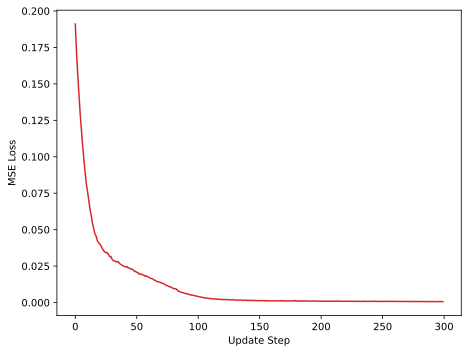

In [15]:
fig, ax = plt.subplots(1, 1, layout="constrained")
color = 'tab:red'
ax.set_xlabel('Update Step')
ax.set_ylabel('MSE Loss')
ax.plot(loss_history, color=color, label='Loss')

### RDF

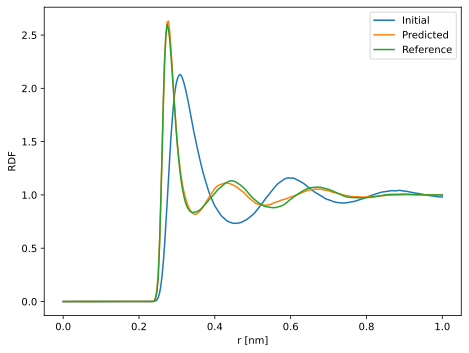

In [16]:
fig, ax = plt.subplots(1, 1, layout="constrained")
r = onp.linspace(0, 1, 300)
ax.plot(r, predicted_quantities[0]["rdf"], label='Initial')
ax.plot(r, predicted_quantities[num_updates]["rdf"], label='Predicted')
ax.plot(r, targets["rdf"]["target"], label='Reference')
ax.set_xlabel("r [nm]")
ax.set_ylabel("RDF")
ax.legend()

### ADF

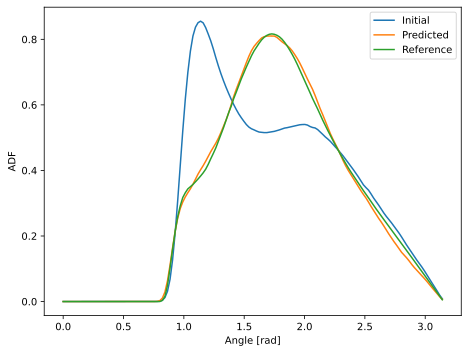

In [17]:
fig, ax = plt.subplots(1, 1, layout="constrained")
alpha = onp.linspace(0, onp.pi, 150)
ax.plot(alpha, predicted_quantities[0]["adf"], label='Initial')
ax.plot(alpha, predicted_quantities[num_updates]["adf"], label='Predicted')
ax.plot(alpha, targets["adf"]["target"], label='Reference')
ax.set_xlabel("Angle [rad]")
ax.set_ylabel("ADF")
ax.legend()

### Pressure

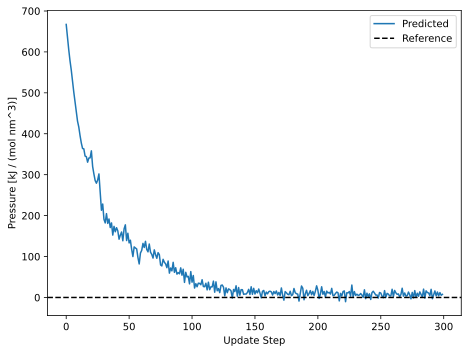

In [18]:
fig, ax = plt.subplots(1, 1, layout="constrained")
ax.set_xlabel('Update Step')
ax.set_ylabel('Pressure [kJ / (mol nm^3)]')
ax.plot([preds["pressure"] for preds in predicted_quantities.values()], label='Predicted')
ax.axhline(y=pressure_target, linestyle='--', label='Reference', color='k')
ax.legend()

## References

[^Thaler2021]: Thaler, S.; Zavadlav, J. Learning Neural Network Potentials from Experimental Data via Differentiable Trajectory Reweighting. _Nat Commun_ **2021**, _12_ (1), 6884. [https://doi.org/10.1038/s41467-021-27241-4](https://doi.org/10.1038/s41467-021-27241-4).

[^Reith2003]: Reith, D.; Pütz, M.; Müller-Plathe, F. Deriving Effective Mesoscale Potentials from Atomistic Simulations: Mesoscale Potentials from Atomistic Simulations. _J. Comput. Chem._ **2003**, _24_ (13), 1624–1636. [https://doi.org/10.1002/jcc.10307](https://doi.org/10.1002/jcc.10307).

[^Lyubartsev1995]: Lyubartsev, A. P.; Laaksonen, A. Calculation of Effective Interaction Potentials from Radial Distribution Functions: A Reverse Monte Carlo Approach. _Phys. Rev. E_ **1995**, _52_ (4), 3730–3737. [https://doi.org/10.1103/PhysRevE.52.3730](https://doi.org/10.1103/PhysRevE.52.3730).

[^Dhabal2014]: Dhabal, D.; Singh, M.; Wikfeldt, K. T.; Chakravarty, C. Triplet Correlation Functions in Liquid Water. _The Journal of Chemical Physics_ **2014**, _141_ (17), 174504. [https://doi.org/10.1063/1.4898755](https://doi.org/10.1063/1.4898755).

[^Torrie1977]: Torrie, G. M.; Valleau, J. P. Nonphysical Sampling Distributions in Monte Carlo Free-Energy Estimation: Umbrella Sampling. _Journal of Computational Physics_ **1977**, _23_ (2), 187–199. [https://doi.org/10.1016/0021-9991(77)90121-8](https://doi.org/10.1016/0021-9991(77)90121-8).

[^DimeNet]: Gasteiger, J.; Giri, S.; Margraf, J. T.; Günnemann, S. _Fast and Uncertainty-Aware Directional Message Passing for Non-Equilibrium Molecules_. [http://arxiv.org/abs/2011.14115](http://arxiv.org/abs/2011.14115) (accessed 2023-06-29).

[^Soper2008]: Soper, A. K.; Benmore, C. J. Quantum Differences between Heavy and Light Water. _Phys. Rev. Lett._ **2008**, _101_ (6), 065502. [https://doi.org/10.1103/PhysRevLett.101.065502](https://doi.org/10.1103/PhysRevLett.101.065502).